In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools

# For statistical models
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For GARCH modeling
from arch import arch_model

# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For regime switching
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Ensure plots render inline
%matplotlib inline


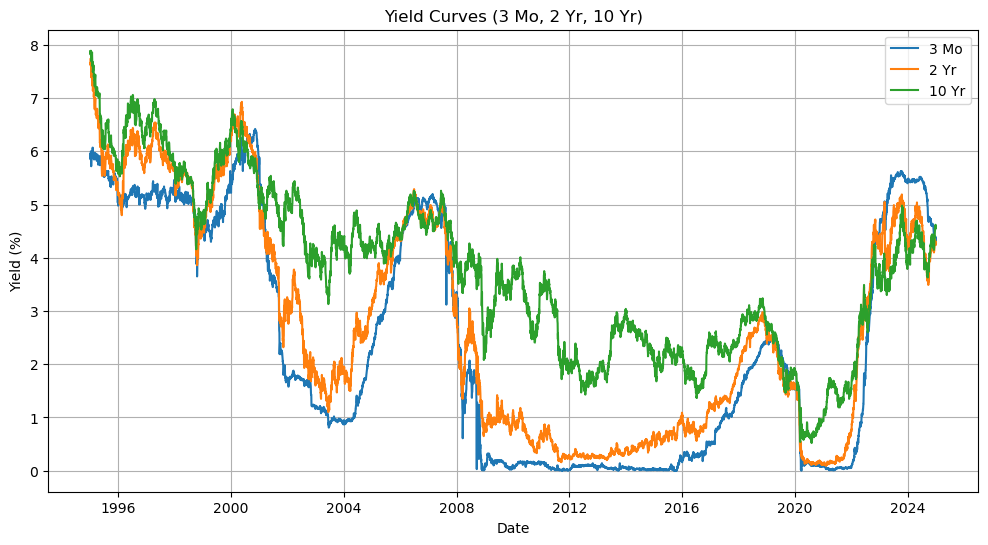

In [3]:
# Load the CSV and filter dates from 1995 onward
df = pd.read_csv('Yield Curve.csv')
# Adjust the date format as needed – here we assume m/d/yy
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df = df[df['Date'] >= '1995-01-01']
df.set_index('Date', inplace=True)

# Use only the three series: "3 Mo", "2 Yr", "10 Yr"
data = df[['3 Mo', '2 Yr', '10 Yr']]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['3 Mo'], label='3 Mo', linewidth=1.5)
plt.plot(data.index, data['2 Yr'], label='2 Yr', linewidth=1.5)
plt.plot(data.index, data['10 Yr'], label='10 Yr', linewidth=1.5)
plt.title('Yield Curves (3 Mo, 2 Yr, 10 Yr)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()



Fitting GARCH(1,1) for 3 Mo returns...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   3 Mo   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -19203.5
Distribution:                  Normal   AIC:                           38415.0
Method:            Maximum Likelihood   BIC:                           38442.7
                                        No. Observations:                 7484
Date:                Fri, Feb 21 2025   Df Residuals:                     7483
Time:                        08:37:10   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu          

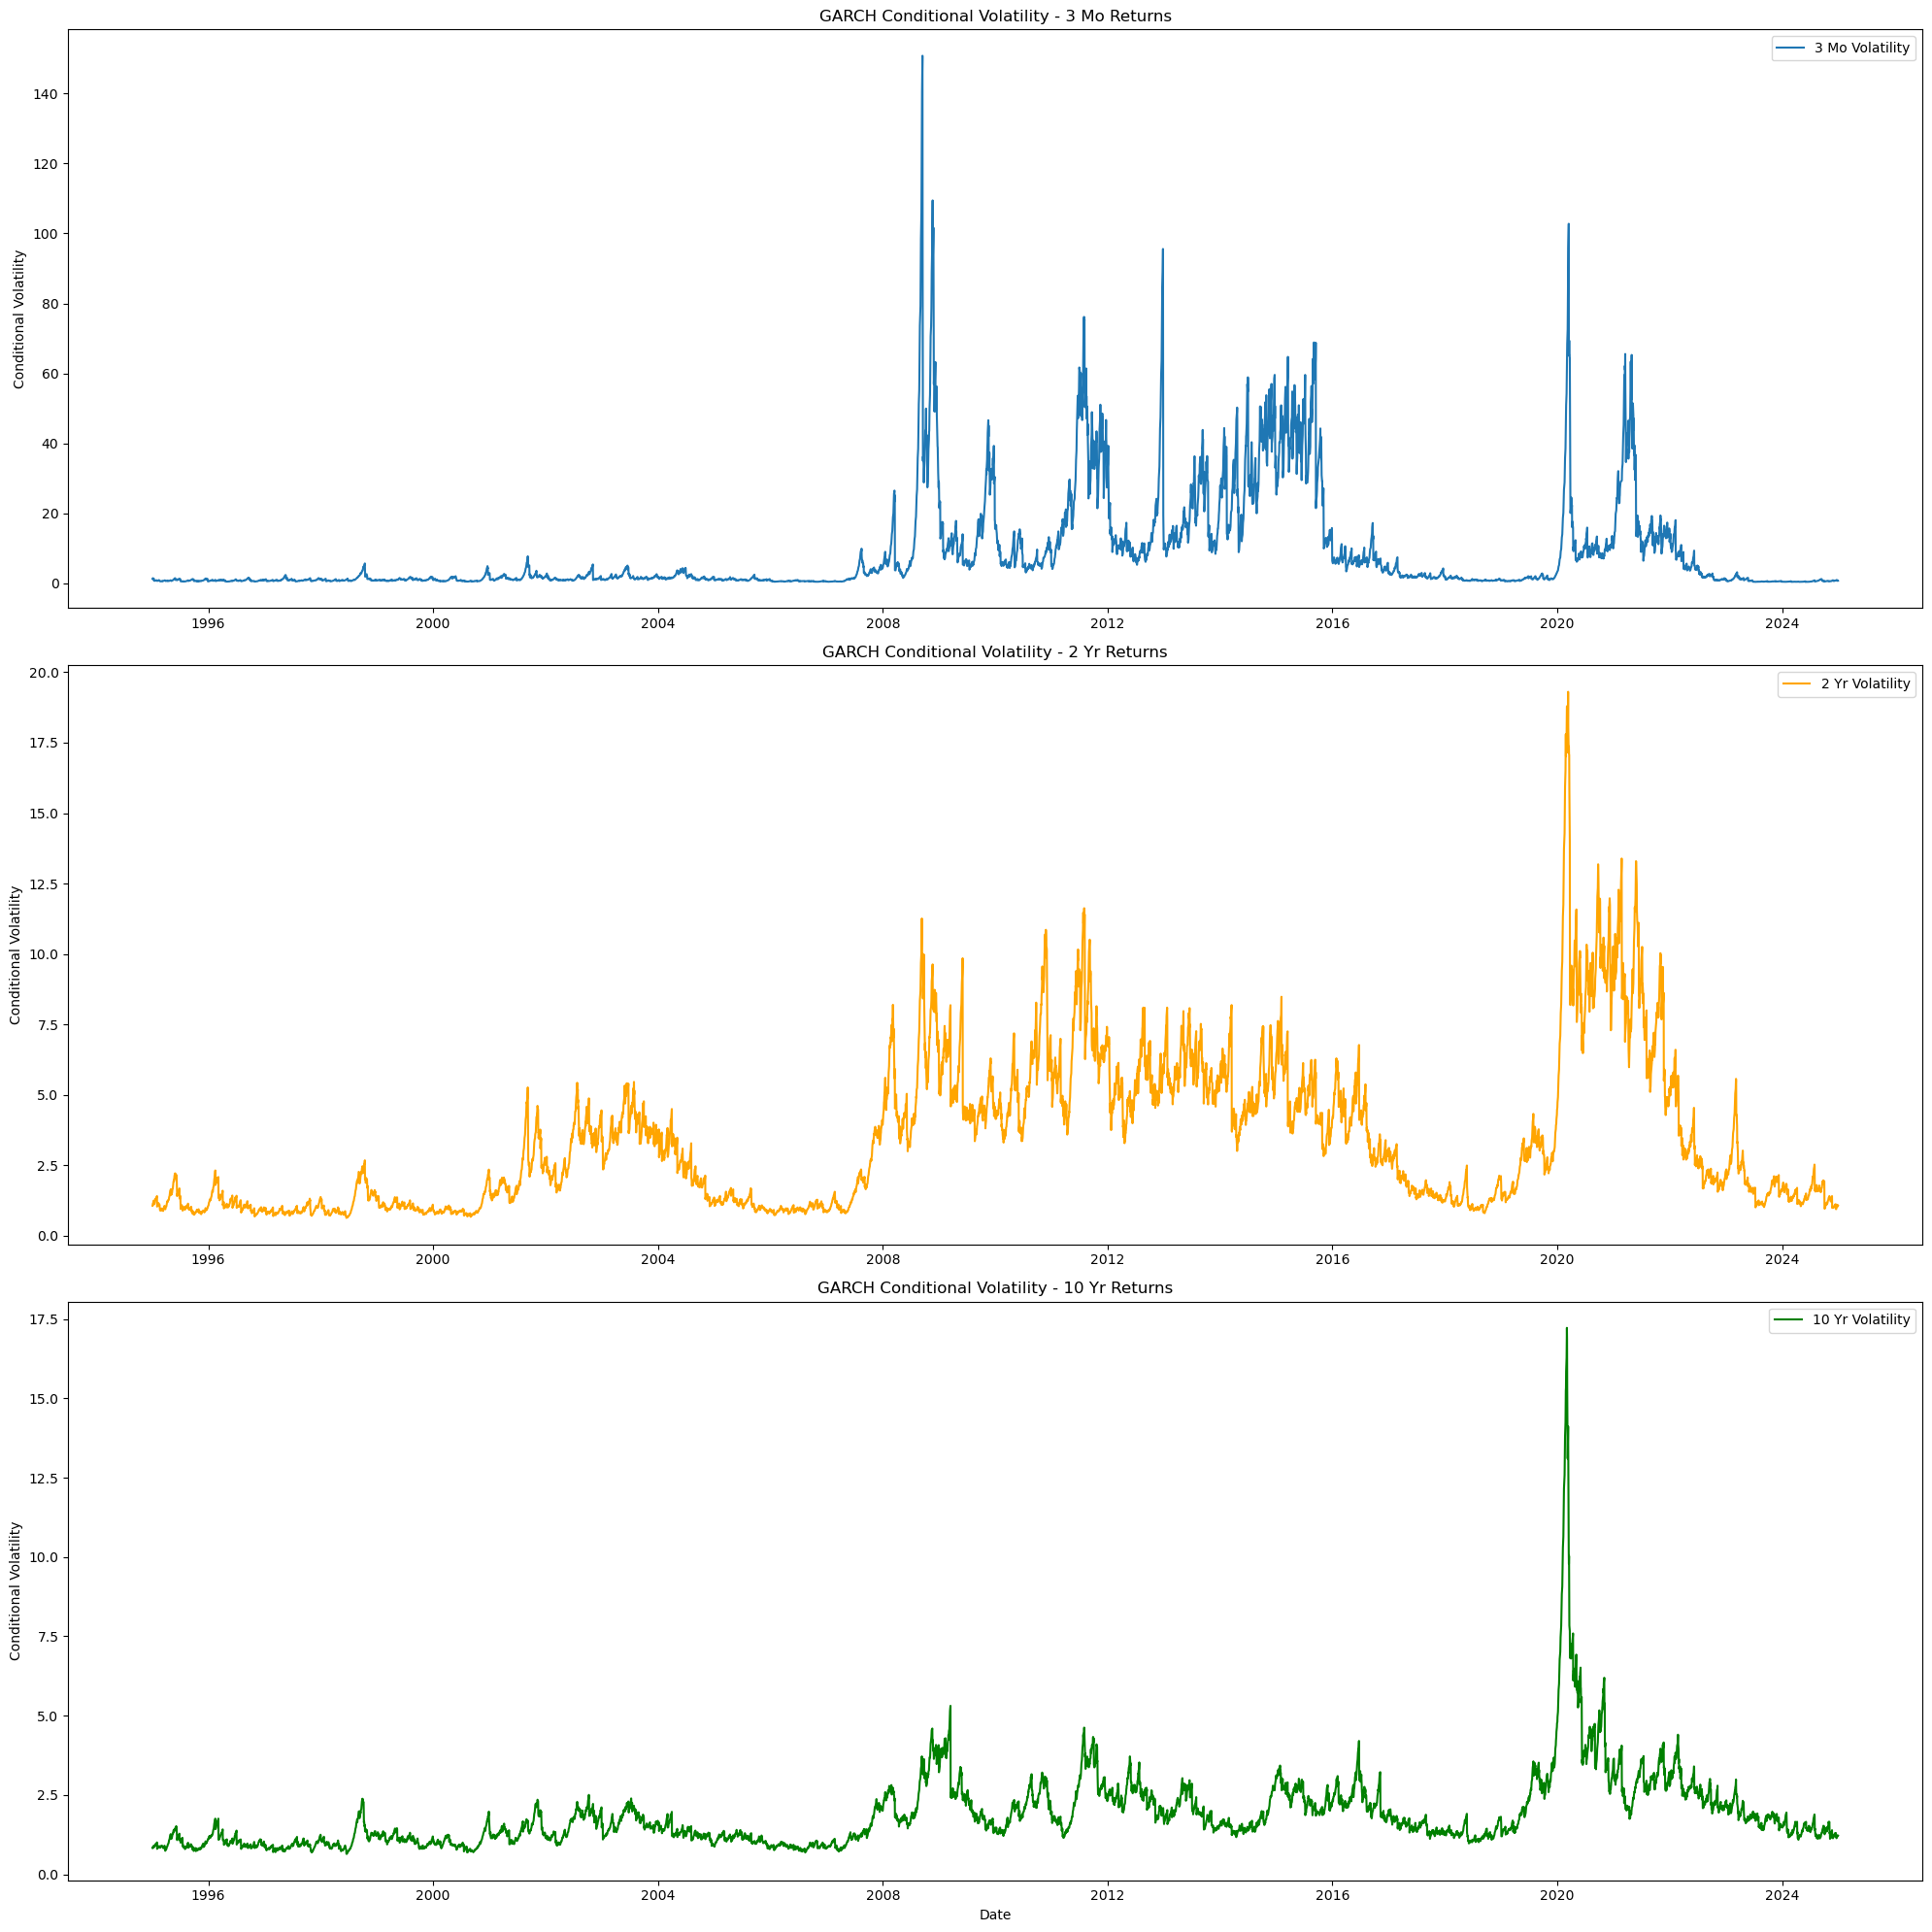

In [4]:
# Remove rows with non-positive yields (to avoid issues with log)
data_clean = data[(data > 0).all(axis=1)]
# Compute log returns (drop initial NaN) and handle inf values
returns = np.log(data_clean).diff() * 100
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

garch_results = {}
for col in returns.columns:
    print(f"\nFitting GARCH(1,1) for {col} returns...")
    am = arch_model(returns[col], vol='Garch', p=1, q=1, rescale=False)
    res = am.fit(disp='off')
    garch_results[col] = res
    print(res.summary())

plt.figure(figsize=(20, 20))

# Subplot 1: 3 Mo
ax1 = plt.subplot(3, 1, 1)
ax1.plot(garch_results['3 Mo'].conditional_volatility, label='3 Mo Volatility')
ax1.set_title('GARCH Conditional Volatility - 3 Mo Returns')
ax1.set_ylabel('Conditional Volatility')
ax1.legend()

# Subplot 2: 2 Yr (share the same x-axis as ax1)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(garch_results['2 Yr'].conditional_volatility, label='2 Yr Volatility', color='orange')
ax2.set_title('GARCH Conditional Volatility - 2 Yr Returns')
ax2.set_ylabel('Conditional Volatility')
ax2.legend()

# Subplot 3: 10 Yr (share the same x-axis as ax1)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(garch_results['10 Yr'].conditional_volatility, label='10 Yr Volatility', color='green')
ax3.set_title('GARCH Conditional Volatility - 10 Yr Returns')
ax3.set_xlabel('Date')
ax3.set_ylabel('Conditional Volatility')
ax3.legend()

plt.tight_layout()
plt.show()




Fitting GARCH(1,1) for 3 Mo returns...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   3 Mo   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -19203.5
Distribution:                  Normal   AIC:                           38415.0
Method:            Maximum Likelihood   BIC:                           38442.7
                                        No. Observations:                 7484
Date:                Fri, Feb 21 2025   Df Residuals:                     7483
Time:                        08:37:15   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu          

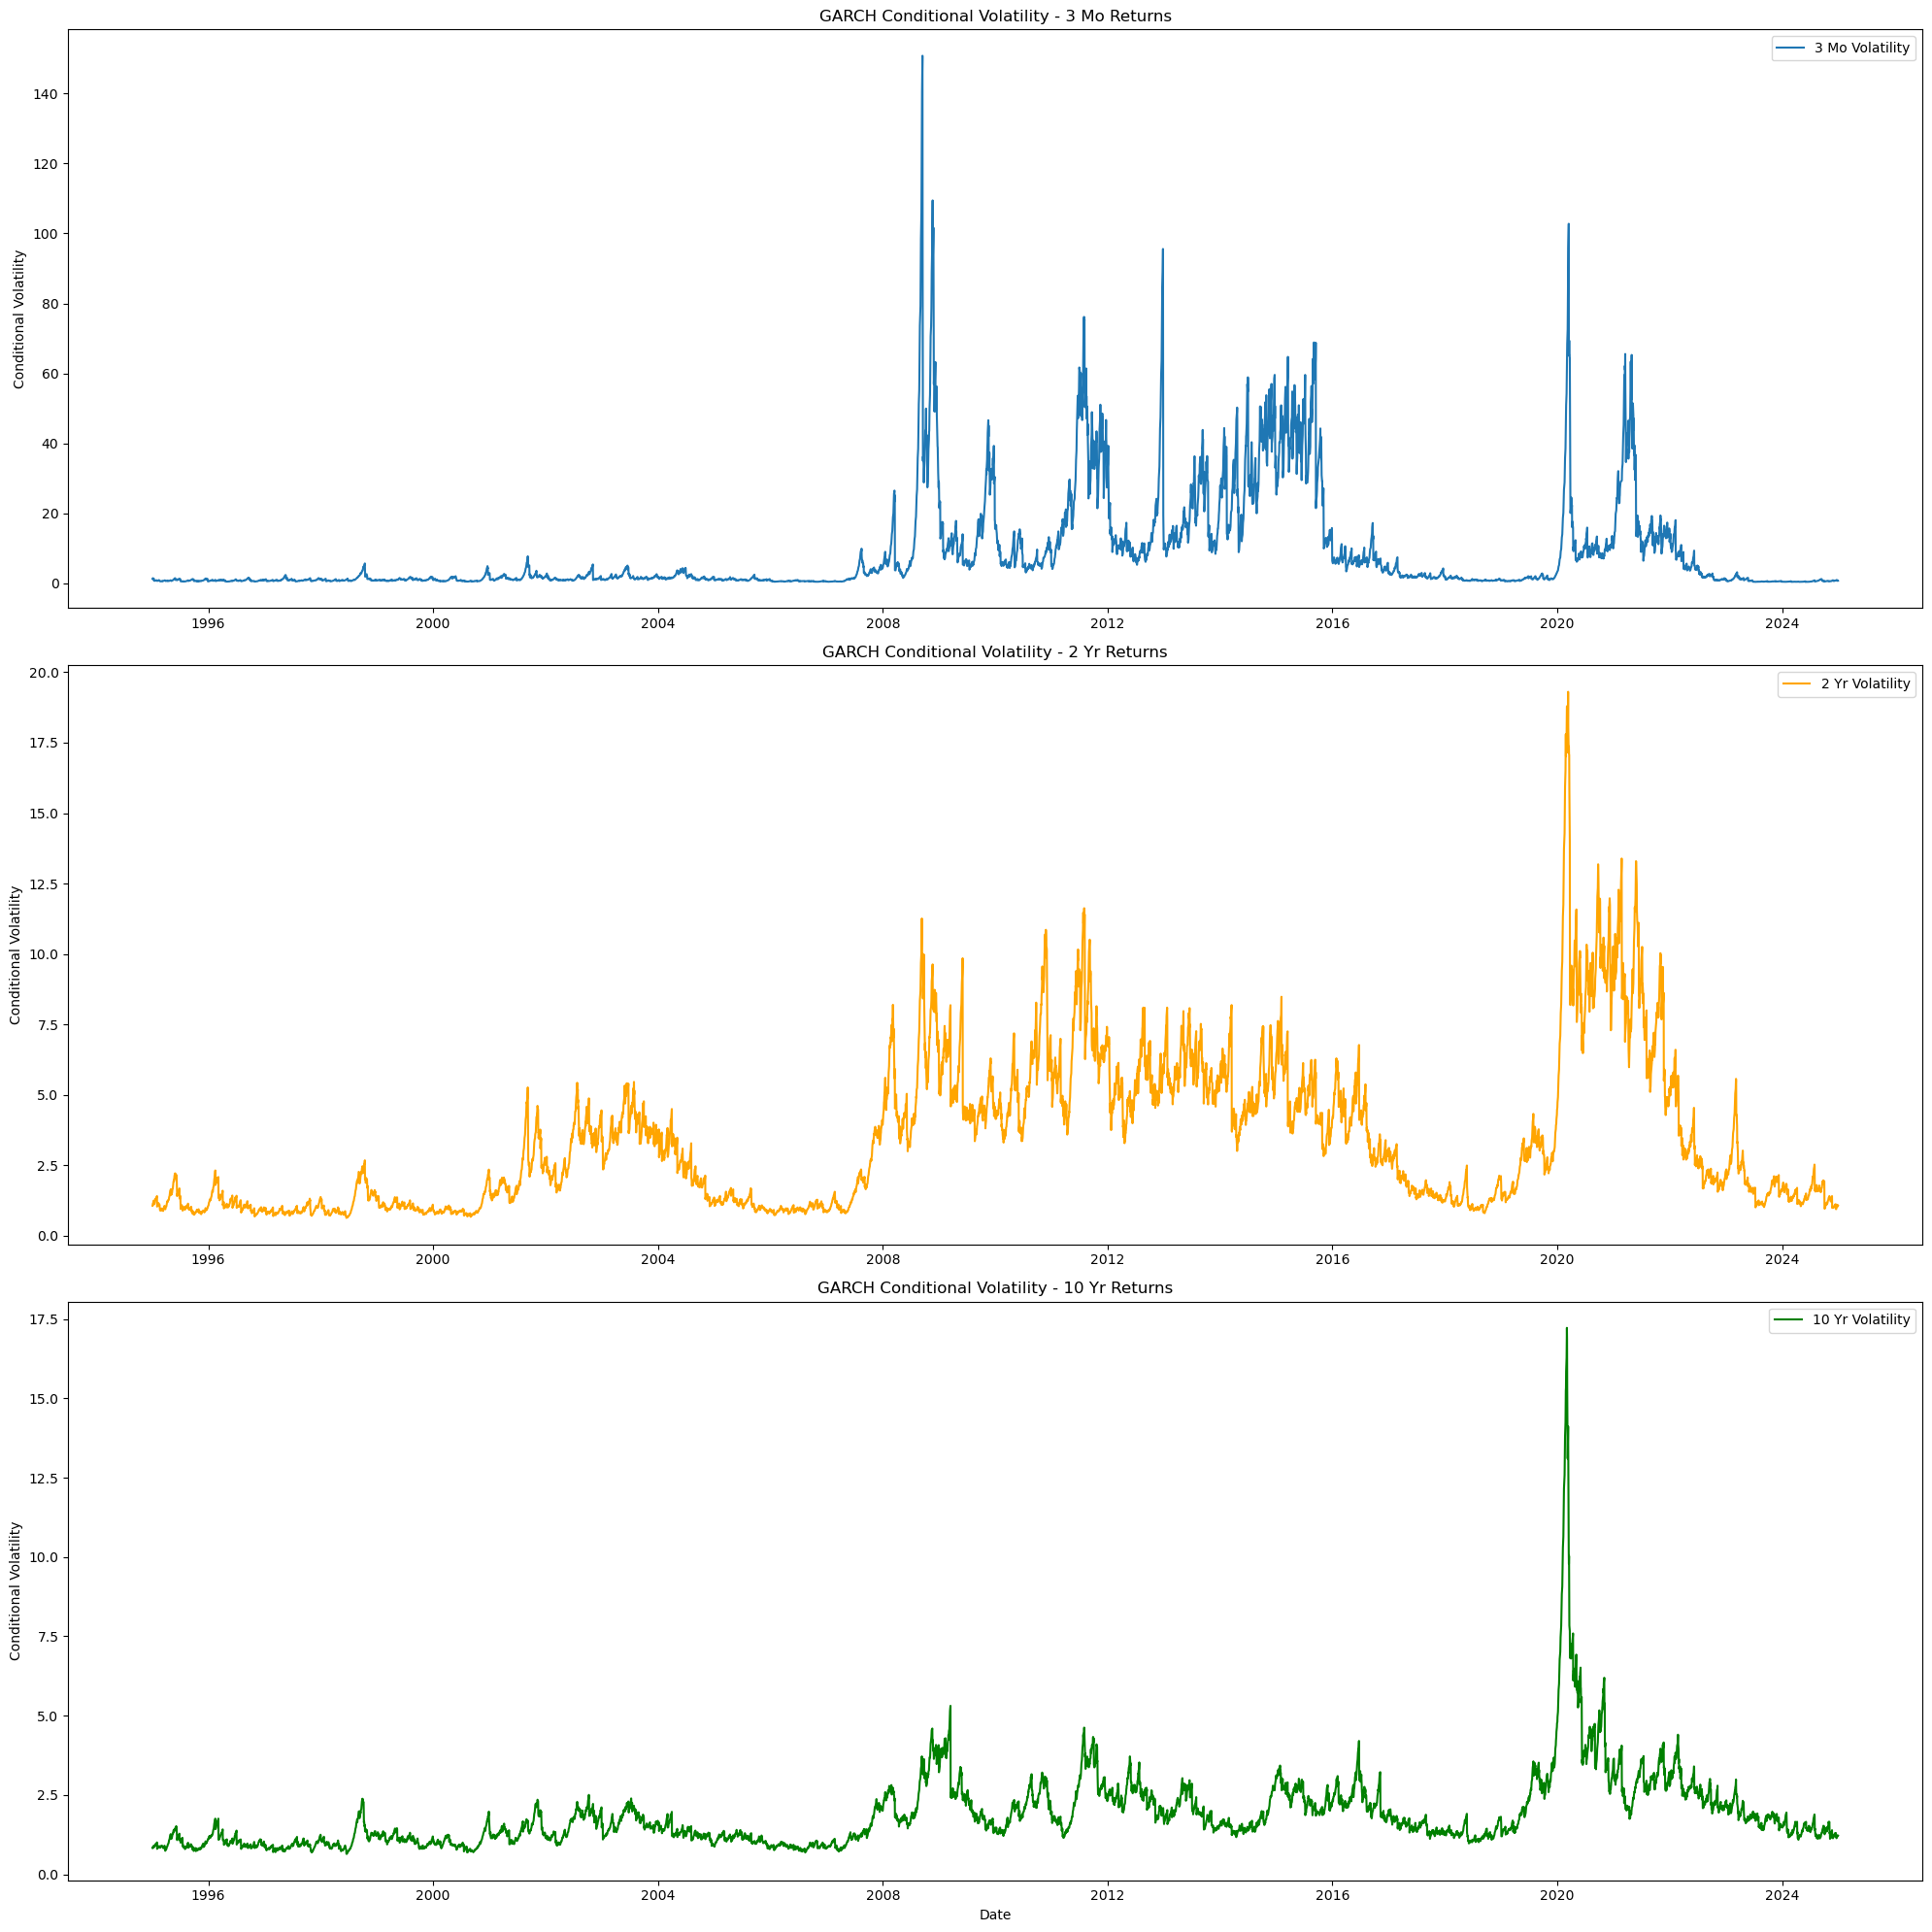

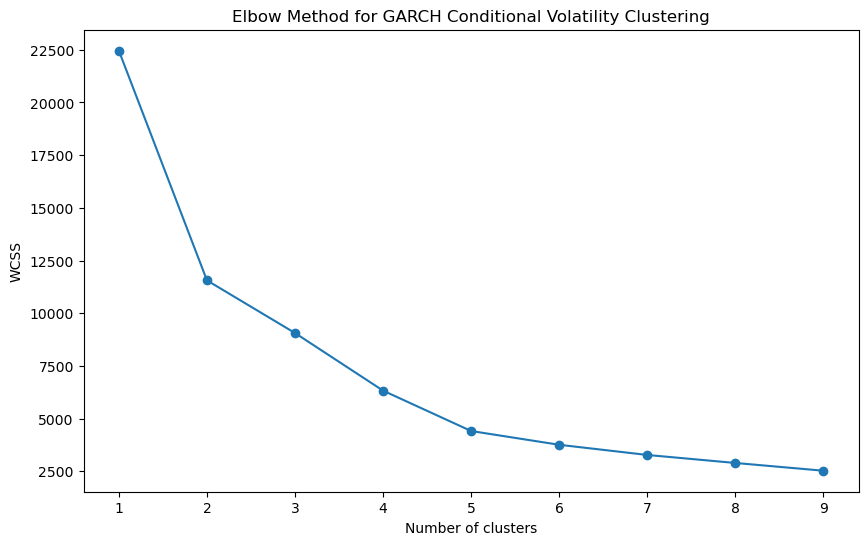

c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


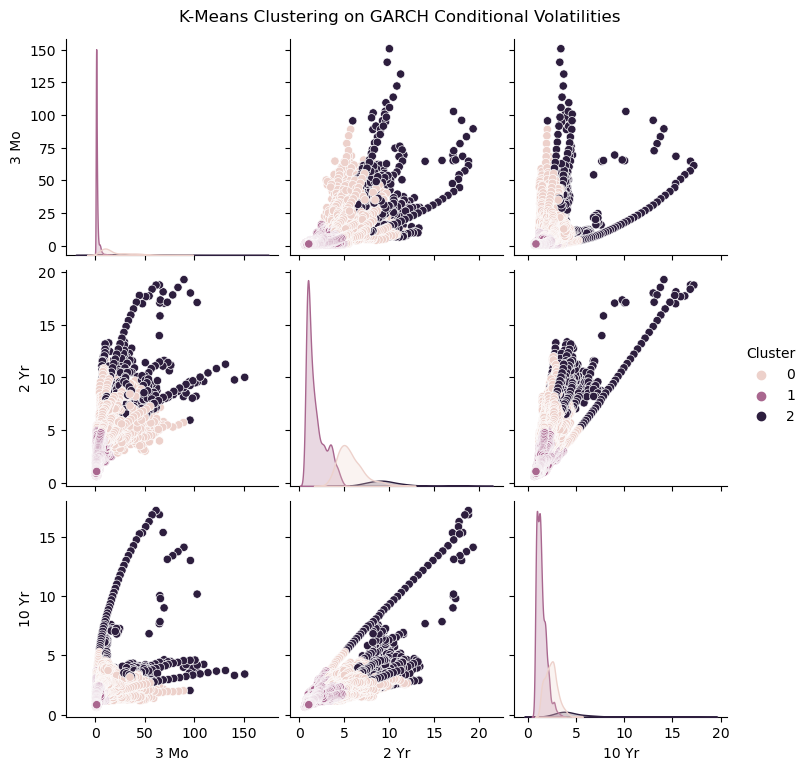


Summary statistics for GARCH Cluster 0:
              3 Mo         2 Yr        10 Yr  Cluster
count  2173.000000  2173.000000  2173.000000   2173.0
mean     19.506603     5.662586     2.395216      0.0
std      14.734143     1.446860     0.663116      0.0
min       1.105747     2.566216     1.159581      0.0
25%       8.718403     4.643567     1.896987      0.0
50%      13.515956     5.385494     2.370954      0.0
75%      28.767180     6.423890     2.791485      0.0
max      89.000865    11.975468     5.269546      0.0

Summary statistics for GARCH Cluster 1:
              3 Mo         2 Yr        10 Yr  Cluster
count  4899.000000  4899.000000  4899.000000   4899.0
mean      1.557469     1.812880     1.371272      1.0
std       1.634196     1.019464     0.489255      0.0
min       0.354995     0.625113     0.642733      1.0
25%       0.685171     0.993425     0.994078      1.0
50%       0.993143     1.433653     1.258931      1.0
75%       1.669075     2.426549     1.645632      1.0


In [5]:
# --- GARCH Modeling for Yield Returns & Clustering on Conditional Volatility ---

# Remove rows with non-positive yields (to avoid issues with log)
data_clean = data[(data > 0).all(axis=1)]

# Compute log returns (drop initial NaN) and handle inf values
returns = np.log(data_clean).diff() * 100
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

# Fit GARCH(1,1) models for each series and store results in a dictionary
from arch import arch_model
garch_results = {}
for col in returns.columns:
    print(f"\nFitting GARCH(1,1) for {col} returns...")
    am = arch_model(returns[col], vol='Garch', p=1, q=1, rescale=False)
    res = am.fit(disp='off')
    garch_results[col] = res
    print(res.summary())

# Plot conditional volatilities in vertically aligned subplots
plt.figure(figsize=(20, 20))

# Subplot 1: 3 Mo
ax1 = plt.subplot(3, 1, 1)
ax1.plot(garch_results['3 Mo'].conditional_volatility, label='3 Mo Volatility')
ax1.set_title('GARCH Conditional Volatility - 3 Mo Returns')
ax1.set_ylabel('Conditional Volatility')
ax1.legend()

# Subplot 2: 2 Yr (shared x-axis)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(garch_results['2 Yr'].conditional_volatility, label='2 Yr Volatility', color='orange')
ax2.set_title('GARCH Conditional Volatility - 2 Yr Returns')
ax2.set_ylabel('Conditional Volatility')
ax2.legend()

# Subplot 3: 10 Yr (shared x-axis)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(garch_results['10 Yr'].conditional_volatility, label='10 Yr Volatility', color='green')
ax3.set_title('GARCH Conditional Volatility - 10 Yr Returns')
ax3.set_xlabel('Date')
ax3.set_ylabel('Conditional Volatility')
ax3.legend()

plt.tight_layout()
plt.show()

# --- Clustering on GARCH Conditional Volatility ---

# Create a DataFrame of conditional volatilities from the GARCH models
cond_vol_df = pd.DataFrame({
    '3 Mo': garch_results['3 Mo'].conditional_volatility,
    '2 Yr': garch_results['2 Yr'].conditional_volatility,
    '10 Yr': garch_results['10 Yr'].conditional_volatility
})
cond_vol_df = cond_vol_df.dropna().copy()  # ensure complete cases

# Scale the conditional volatility data
scaler_vol = StandardScaler()
scaled_vol = scaler_vol.fit_transform(cond_vol_df)

# Determine optimal k using the elbow method
wcss_vol = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_vol)
    wcss_vol.append(km.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 10), wcss_vol, marker='o')
plt.title('Elbow Method for GARCH Conditional Volatility Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Choose k = 3 (for example) and perform clustering
km_vol = KMeans(n_clusters=3, random_state=42)
clusters_vol = km_vol.fit_predict(scaled_vol)
cond_vol_df['Cluster'] = clusters_vol

# Visualize clusters using a pairplot
sns.pairplot(cond_vol_df, hue='Cluster', diag_kind='kde')
plt.suptitle("K-Means Clustering on GARCH Conditional Volatilities", y=1.02)
plt.show()

# Print summary statistics for each cluster
for clust in sorted(cond_vol_df['Cluster'].unique()):
    print(f"\nSummary statistics for GARCH Cluster {clust}:")
    print(cond_vol_df[cond_vol_df['Cluster'] == clust].describe())


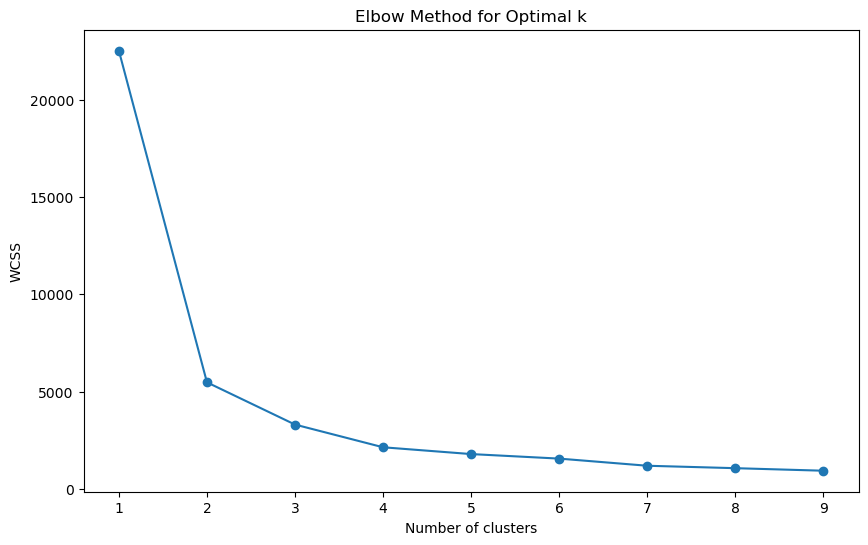

c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


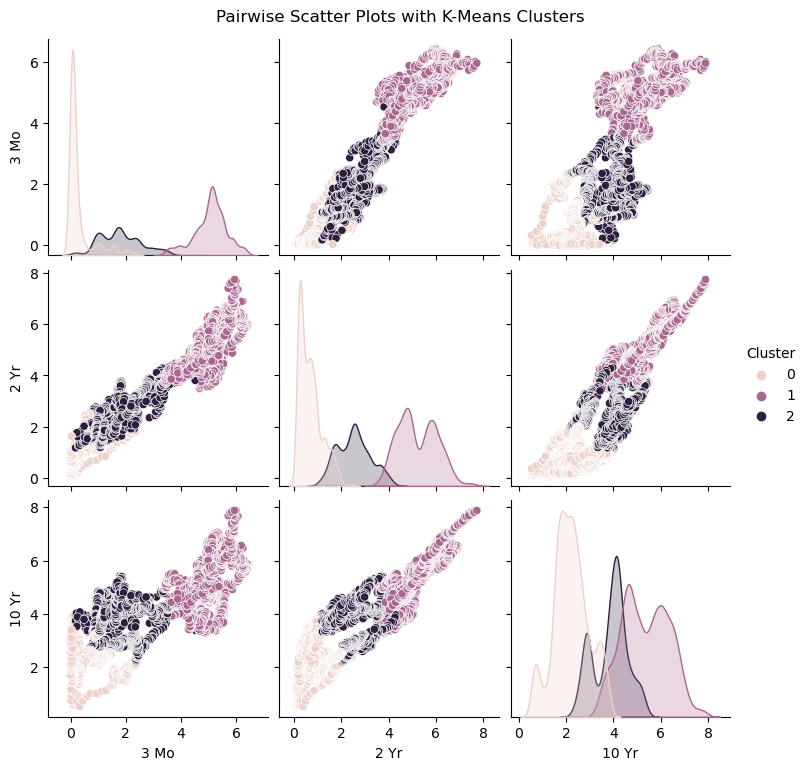


Summary statistics for Cluster 0:
              3 Mo         2 Yr        10 Yr
count  2987.000000  2987.000000  2987.000000
mean      0.295186     0.688447     2.202524
std       0.482674     0.469556     0.733177
min       0.000000     0.090000     0.520000
25%       0.040000     0.290000     1.730000
50%       0.100000     0.590000     2.170000
75%       0.250000     0.930000     2.650000
max       2.350000     2.510000     3.850000

Summary statistics for Cluster 1:
              3 Mo         2 Yr        10 Yr
count  2754.000000  2754.000000  2754.000000
mean      5.066057     5.222574     5.341950
std       0.590263     0.818373     0.975744
min       3.380000     3.490000     3.300000
25%       4.740000     4.590000     4.580000
50%       5.130000     5.060000     5.270000
75%       5.447500     5.880000     6.120000
max       6.420000     7.730000     7.890000

Summary statistics for Cluster 2:
              3 Mo         2 Yr        10 Yr
count  1762.000000  1762.000000  1762.00

In [6]:
# Use only the complete cases for clustering
data_for_clustering = data.dropna().copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Determine optimal k using the elbow method
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,10), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Choose k = 3 (for example) and perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the clusters to the complete-case DataFrame
data_for_clustering['Cluster'] = clusters

sns.pairplot(data_for_clustering, hue='Cluster', diag_kind='kde')
plt.suptitle("Pairwise Scatter Plots with K-Means Clusters", y=1.02)
plt.show()

for cluster in sorted(data_for_clustering['Cluster'].unique()):
    print(f"\nSummary statistics for Cluster {cluster}:")
    print(data_for_clustering[data_for_clustering['Cluster'] == cluster][['3 Mo', '2 Yr', '10 Yr']].describe())


In [7]:
def permutation_entropy(time_series, m=3, delay=1):
    n = len(time_series)
    if n < m * delay:
        return np.nan
    perms = np.array(list(itertools.permutations(range(m))))
    c = np.zeros(len(perms))
    for i in range(n - delay * (m - 1)):
        sorted_index = np.argsort(time_series[i: i + delay * m: delay])
        for j, p in enumerate(perms):
            if np.array_equal(sorted_index, p):
                c[j] += 1
    c = c[c > 0]
    p = c / np.sum(c)
    pe = -np.sum(p * np.log(p))
    return pe

for col in data.columns:
    # Skip if the column is not a yield series
    if col not in ['3 Mo', '2 Yr', '10 Yr']:
        continue
    pe = permutation_entropy(data[col].dropna().values, m=3, delay=1)
    print(f"Permutation Entropy for {col}: {pe:.4f}")


Permutation Entropy for 3 Mo: 1.6165
Permutation Entropy for 2 Yr: 1.7046
Permutation Entropy for 10 Yr: 1.7180


In [8]:
# - H < 0.5 implies mean-reversion,
# - H ≈ 0.5 indicates a random walk,
# - H > 0.5 suggests trending behavior.

def hurst_exponent(ts):
    """Estimate the Hurst Exponent of a time series."""
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

for col in data.columns:
    if col not in ['3 Mo', '2 Yr', '10 Yr']:
        continue
    h = hurst_exponent(data[col].dropna().values)
    print(f"Hurst Exponent for {col}: {h:.4f}")


Hurst Exponent for 3 Mo: 1.2577
Hurst Exponent for 2 Yr: 1.1643
Hurst Exponent for 10 Yr: 1.0088


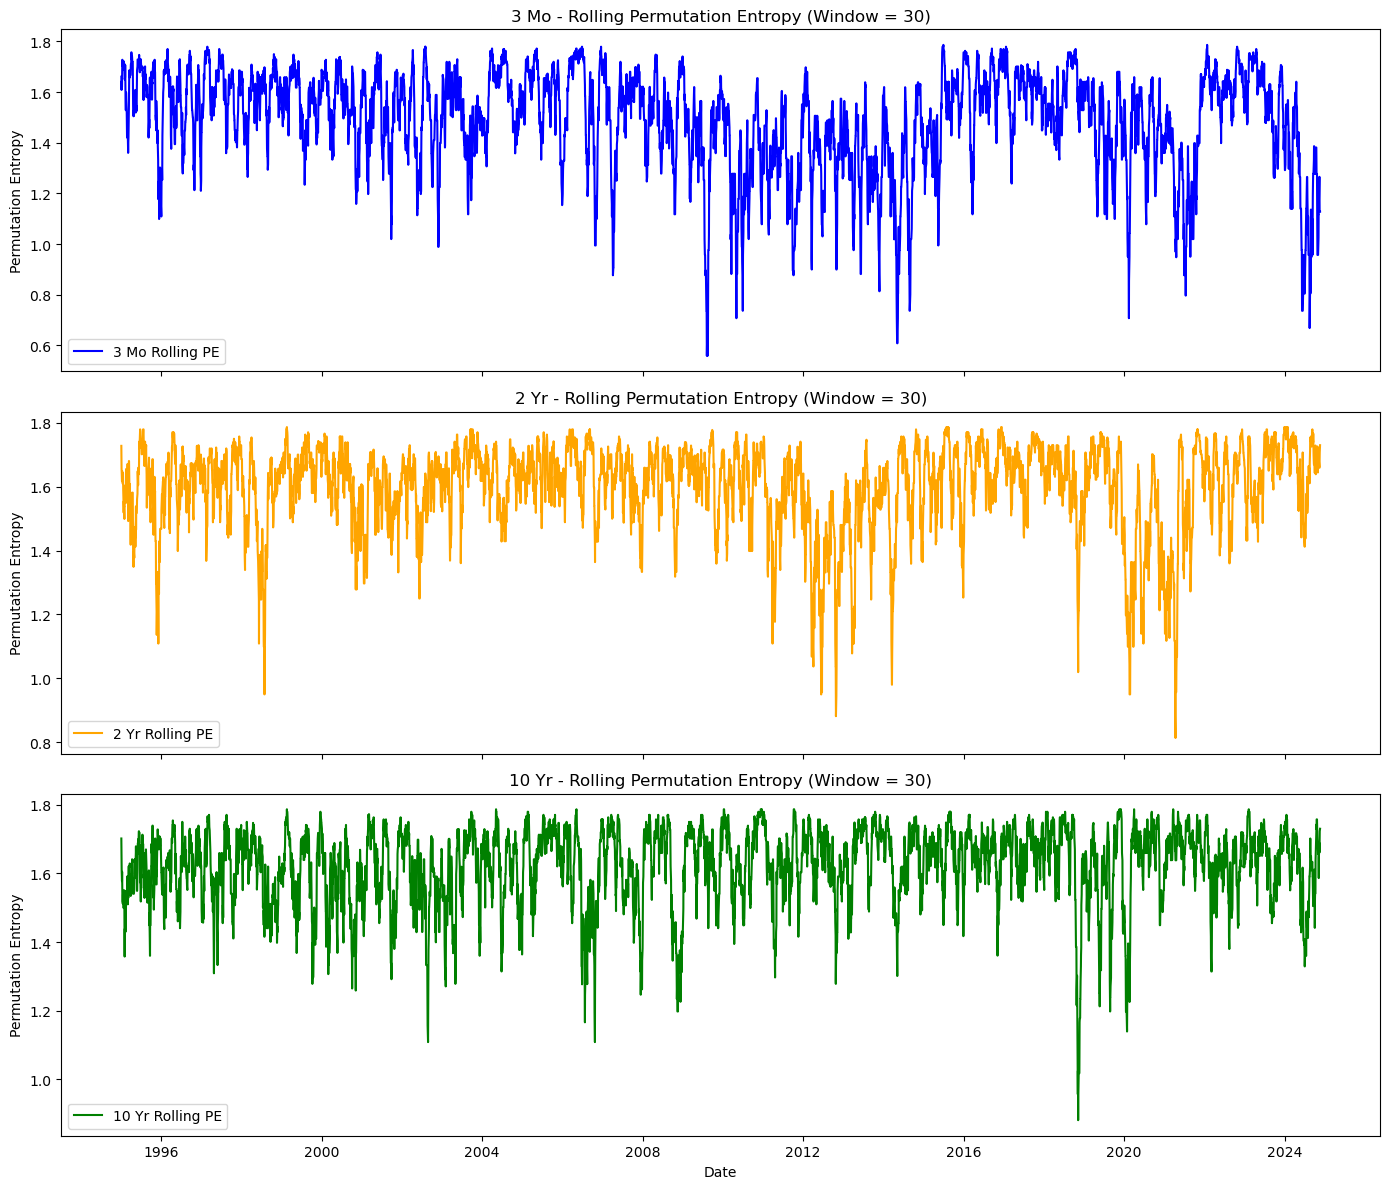

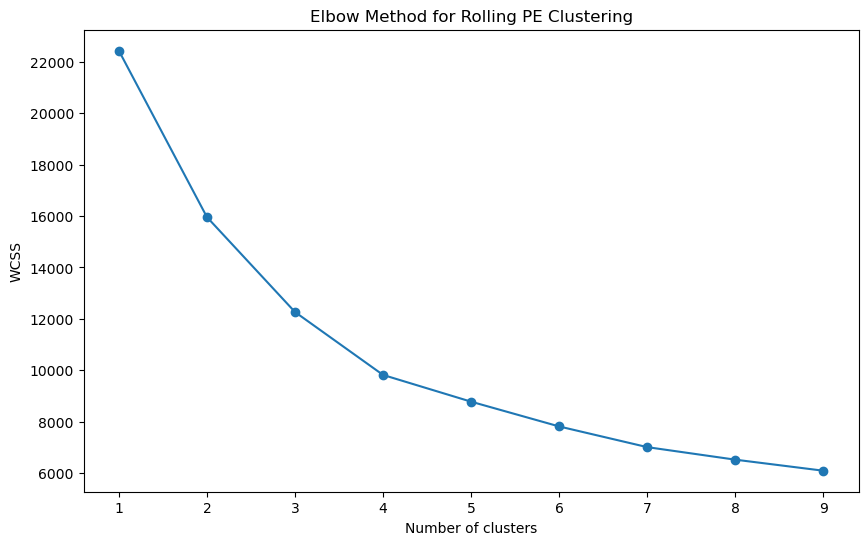

c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


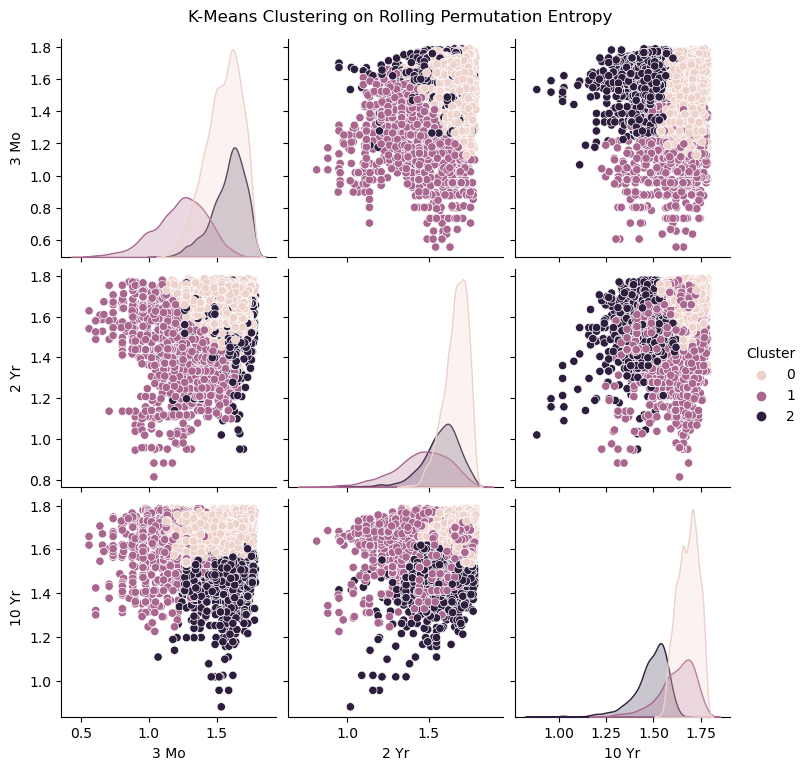


Rolling PE Summary for Cluster 0:
              3 Mo         2 Yr        10 Yr
count  4063.000000  4063.000000  4063.000000
mean      1.550808     1.663152     1.681328
std       0.129339     0.072243     0.054374
min       1.126598     1.346511     1.535290
25%       1.467354     1.619805     1.640965
50%       1.565073     1.672722     1.685893
75%       1.654431     1.719760     1.722629
max       1.786522     1.786522     1.786522

Rolling PE Summary for Cluster 1:
              3 Mo         2 Yr        10 Yr
count  1654.000000  1654.000000  1654.000000
mean      1.234610     1.454225     1.621398
std       0.193405     0.168071     0.097885
min       0.558648     0.813396     1.225619
25%       1.117463     1.358647     1.568856
50%       1.252763     1.470238     1.638855
75%       1.375659     1.579958     1.694917
max       1.671286     1.779331     1.786522

Rolling PE Summary for Cluster 2:
              3 Mo         2 Yr        10 Yr
count  1757.000000  1757.000000  1757.00

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assume 'data' is already loaded with columns '3 Mo', '2 Yr', and '10 Yr'

# Define the permutation entropy function (as before)
def permutation_entropy(time_series, m=3, delay=1):
    import itertools
    n = len(time_series)
    if n < m * delay:
        return np.nan
    perms = np.array(list(itertools.permutations(range(m))))
    c = np.zeros(len(perms))
    for i in range(n - delay * (m - 1)):
        sorted_index = np.argsort(time_series[i: i + delay * m: delay])
        for j, p in enumerate(perms):
            if np.array_equal(sorted_index, p):
                c[j] += 1
    c = c[c > 0]
    p = c / np.sum(c)
    pe = -np.sum(p * np.log(p))
    return pe

# Define rolling PE function with window size = 30
window = 30
def rolling_pe(series, window, m=3, delay=1):
    return series.rolling(window).apply(lambda x: permutation_entropy(x, m, delay), raw=False)

# Compute rolling PE for each series
rolling_PE_3mo = rolling_pe(data['3 Mo'].dropna(), window)
rolling_PE_2yr = rolling_pe(data['2 Yr'].dropna(), window)
rolling_PE_10yr = rolling_pe(data['10 Yr'].dropna(), window)

# Plot all three rolling PE series in vertically aligned subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(rolling_PE_3mo.index, rolling_PE_3mo, label='3 Mo Rolling PE', color='blue')
axes[0].set_title(f'3 Mo - Rolling Permutation Entropy (Window = {window})')
axes[0].set_ylabel('Permutation Entropy')
axes[0].legend()

axes[1].plot(rolling_PE_2yr.index, rolling_PE_2yr, label='2 Yr Rolling PE', color='orange')
axes[1].set_title(f'2 Yr - Rolling Permutation Entropy (Window = {window})')
axes[1].set_ylabel('Permutation Entropy')
axes[1].legend()

axes[2].plot(rolling_PE_10yr.index, rolling_PE_10yr, label='10 Yr Rolling PE', color='green')
axes[2].set_title(f'10 Yr - Rolling Permutation Entropy (Window = {window})')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Permutation Entropy')
axes[2].legend()

plt.tight_layout()
plt.show()

# Build a DataFrame for clustering (align on the common index)
df_PE = pd.concat([rolling_PE_3mo, rolling_PE_2yr, rolling_PE_10yr], axis=1)
df_PE.columns = ['3 Mo', '2 Yr', '10 Yr']
df_PE = df_PE.dropna().copy()  # use complete cases only

# Scale the PE data and perform k-means clustering
scaler_PE = StandardScaler()
scaled_PE = scaler_PE.fit_transform(df_PE)

# (Optional) Plot elbow curve
wcss_pe = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_PE)
    wcss_pe.append(km.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1,10), wcss_pe, marker='o')
plt.title('Elbow Method for Rolling PE Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Use k=3
km_PE = KMeans(n_clusters=3, random_state=42)
clusters_PE = km_PE.fit_predict(scaled_PE)
df_PE['Cluster'] = clusters_PE

# Visualize clusters
sns.pairplot(df_PE, hue='Cluster', diag_kind='kde')
plt.suptitle("K-Means Clustering on Rolling Permutation Entropy", y=1.02)
plt.show()

# Print summary statistics for each PE cluster
for clust in sorted(df_PE['Cluster'].unique()):
    print(f"\nRolling PE Summary for Cluster {clust}:")
    print(df_PE[df_PE['Cluster'] == clust][['3 Mo', '2 Yr', '10 Yr']].describe())


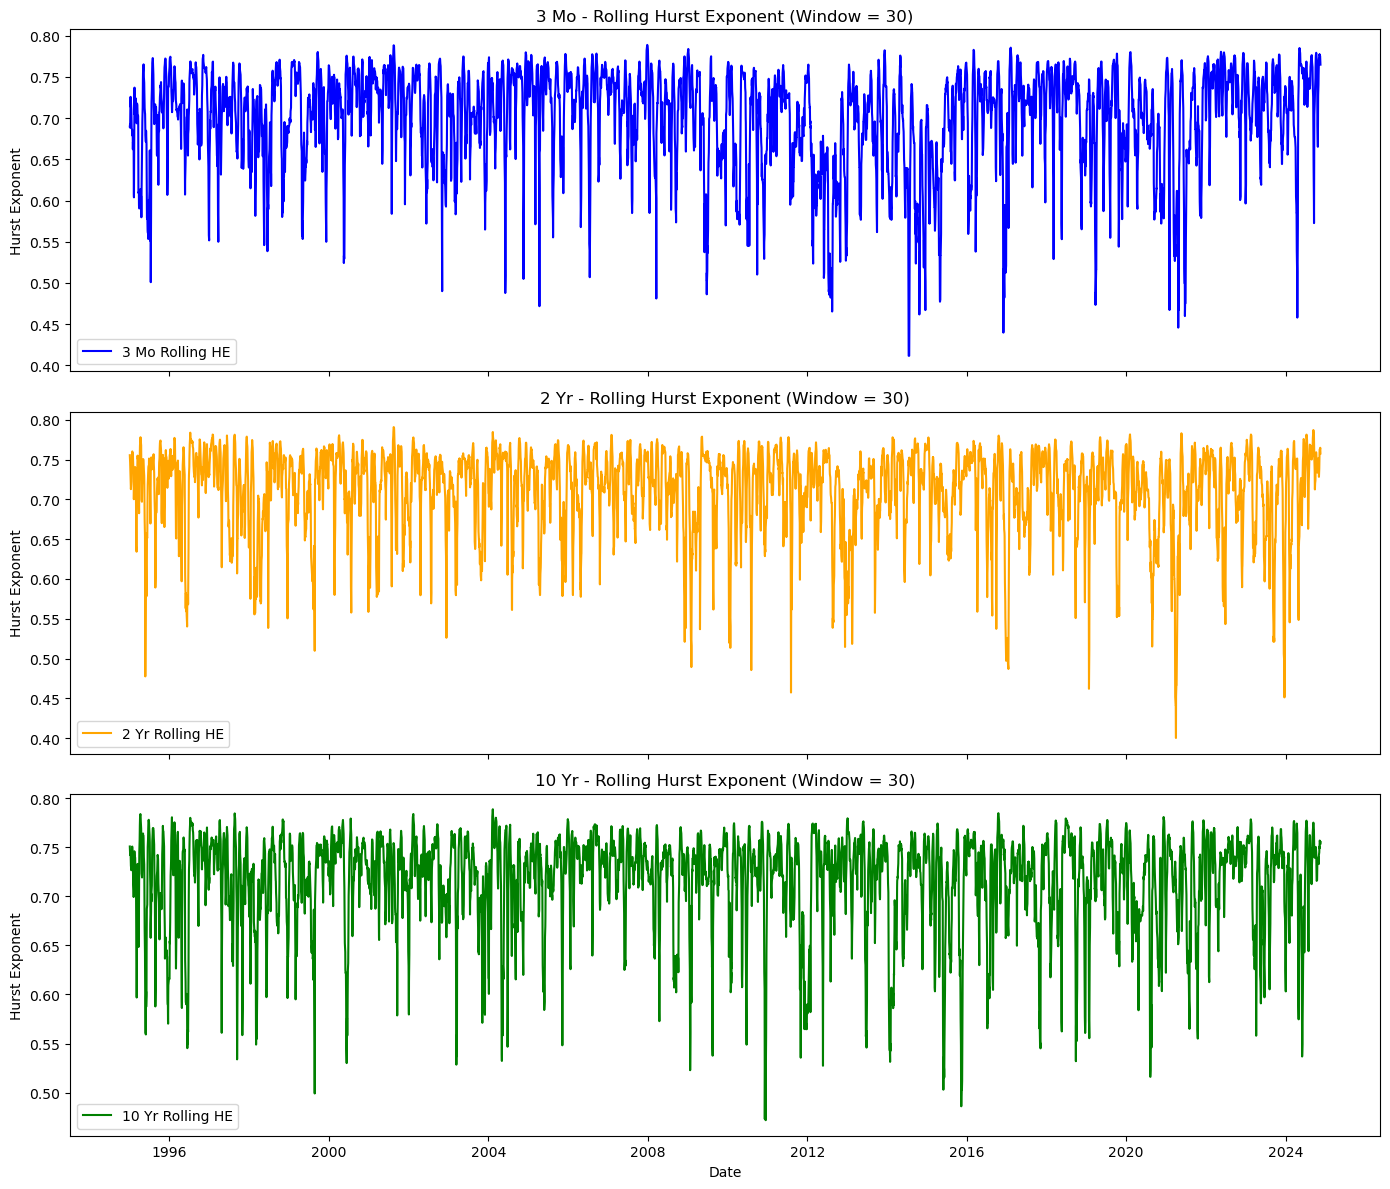

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the R/S based Hurst exponent function
def hurst_exponent(series):
    N = len(series)
    if N < 20:
        return np.nan
    # Compute cumulative deviations from the mean
    Y = np.cumsum(series - np.mean(series))
    R = np.max(Y) - np.min(Y)
    S = np.std(series)
    if S == 0:
        return np.nan
    return np.log(R/S) / np.log(N)

# Define the rolling Hurst function with a fixed window size
def rolling_hurst(series, window_size=90):
    h_vals = []
    for i in range(len(series)):
        if i < window_size:
            h_vals.append(np.nan)
        else:
            window_data = series.iloc[i-window_size:i]
            h = hurst_exponent(window_data)
            h_vals.append(h)
    return pd.Series(h_vals, index=series.index)

# Compute the rolling Hurst exponent for each yield series.
# (Assume 'data' is your DataFrame with columns '3 Mo', '2 Yr', '10 Yr'.)
rolling_HE_3mo = rolling_hurst(data['3 Mo'].dropna(), window_size=30)
rolling_HE_2yr = rolling_hurst(data['2 Yr'].dropna(), window_size=30)
rolling_HE_10yr = rolling_hurst(data['10 Yr'].dropna(), window_size=30)

# Plot the rolling Hurst exponents in vertically aligned subplots.
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(rolling_HE_3mo.index, rolling_HE_3mo, label='3 Mo Rolling HE', color='blue')
axes[0].set_title('3 Mo - Rolling Hurst Exponent (Window = 30)')
axes[0].set_ylabel('Hurst Exponent')
axes[0].legend()

axes[1].plot(rolling_HE_2yr.index, rolling_HE_2yr, label='2 Yr Rolling HE', color='orange')
axes[1].set_title('2 Yr - Rolling Hurst Exponent (Window = 30)')
axes[1].set_ylabel('Hurst Exponent')
axes[1].legend()

axes[2].plot(rolling_HE_10yr.index, rolling_HE_10yr, label='10 Yr Rolling HE', color='green')
axes[2].set_title('10 Yr - Rolling Hurst Exponent (Window = 30)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Hurst Exponent')
axes[2].legend()

plt.tight_layout()
plt.show()



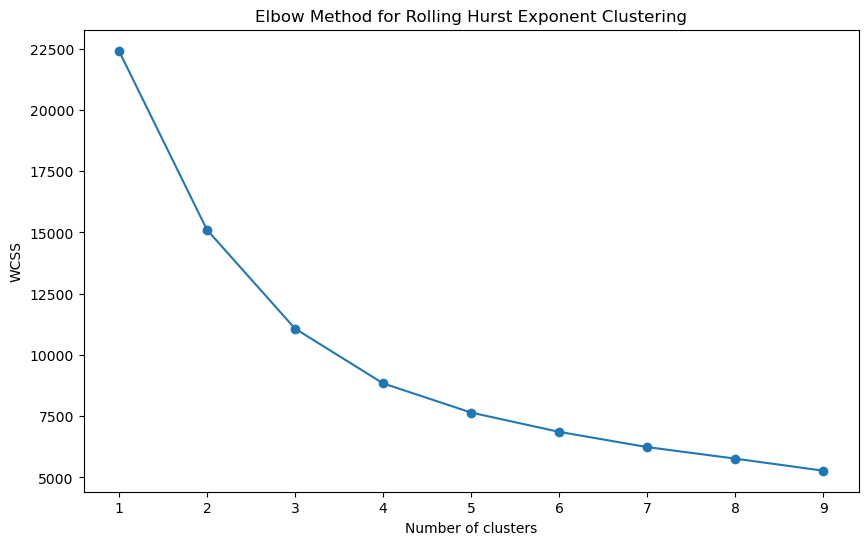

c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


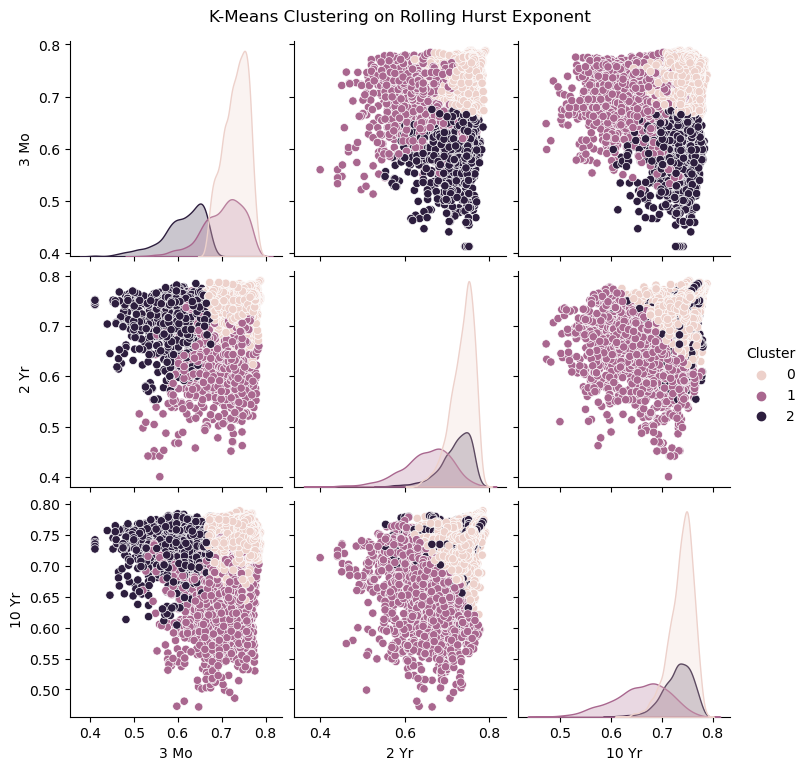


Rolling HE Summary for Cluster 0:
              3 Mo         2 Yr        10 Yr
count  4197.000000  4197.000000  4197.000000
mean      0.731147     0.735767     0.737544
std       0.027705     0.027930     0.024284
min       0.661944     0.617673     0.621137
25%       0.710630     0.719301     0.724010
50%       0.734582     0.741163     0.741616
75%       0.753322     0.756375     0.754419
max       0.788705     0.790854     0.788826

Rolling HE Summary for Cluster 1:
              3 Mo         2 Yr        10 Yr
count  1799.000000  1799.000000  1799.000000
mean      0.703425     0.651404     0.657634
std       0.046655     0.057933     0.054695
min       0.512519     0.400260     0.471824
25%       0.673991     0.617243     0.622562
50%       0.710541     0.658517     0.663661
75%       0.738912     0.693077     0.698045
max       0.784863     0.777954     0.778376

Rolling HE Summary for Cluster 2:
              3 Mo         2 Yr        10 Yr
count  1477.000000  1477.000000  1477.00

In [11]:
# Build a DataFrame for rolling HE using the previously computed series
df_HE = pd.concat([rolling_HE_3mo, rolling_HE_2yr, rolling_HE_10yr], axis=1)
df_HE.columns = ['3 Mo', '2 Yr', '10 Yr']
df_HE = df_HE.dropna().copy()  # Use only complete cases

# Check if we have any valid HE values
if df_HE.empty:
    print("No valid rolling HE values available for clustering.")
else:
    # Scale the rolling HE data
    scaler_HE = StandardScaler()
    scaled_HE = scaler_HE.fit_transform(df_HE)
    
    # Determine the optimal number of clusters via an elbow plot
    wcss_he = []
    for k in range(1, 10):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(scaled_HE)
        wcss_he.append(km.inertia_)
    
    plt.figure(figsize=(10,6))
    plt.plot(range(1,10), wcss_he, marker='o')
    plt.title('Elbow Method for Rolling Hurst Exponent Clustering')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # For this example, choose k = 3 and perform clustering
    km_HE = KMeans(n_clusters=3, random_state=42)
    clusters_HE = km_HE.fit_predict(scaled_HE)
    df_HE['Cluster'] = clusters_HE
    
    # Visualize the clusters with a pairplot
    sns.pairplot(df_HE, hue='Cluster', diag_kind='kde')
    plt.suptitle("K-Means Clustering on Rolling Hurst Exponent", y=1.02)
    plt.show()
    
    # Print summary statistics for each cluster
    for clust in sorted(df_HE['Cluster'].unique()):
        print(f"\nRolling HE Summary for Cluster {clust}:")
        print(df_HE[df_HE['Cluster'] == clust][['3 Mo', '2 Yr', '10 Yr']].describe())

In [12]:
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cluster_series(series, n_clusters=3):
    """Run k-means clustering on a single pandas Series (after dropping NAs) 
       and return a Series of cluster labels with the same index."""
    s = series.dropna()
    X = s.values.reshape(-1, 1)
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = km.fit_predict(X)
    return pd.Series(clusters, index=s.index)

# --- Create individual cluster assignments for each measure and maturity ---

# For GARCH: use the conditional volatility series from the GARCH models.
garch_3mo_cluster = cluster_series(garch_results['3 Mo'].conditional_volatility, n_clusters=3)
garch_2yr_cluster = cluster_series(garch_results['2 Yr'].conditional_volatility, n_clusters=3)
garch_10yr_cluster = cluster_series(garch_results['10 Yr'].conditional_volatility, n_clusters=3)

# For PE: use the rolling permutation entropy series.
pe_3mo_cluster = cluster_series(rolling_PE_3mo, n_clusters=3)
pe_2yr_cluster = cluster_series(rolling_PE_2yr, n_clusters=3)
pe_10yr_cluster = cluster_series(rolling_PE_10yr, n_clusters=3)

# For HE: use the rolling Hurst exponent series.
he_3mo_cluster = cluster_series(rolling_HE_3mo, n_clusters=3)
he_2yr_cluster = cluster_series(rolling_HE_2yr, n_clusters=3)
he_10yr_cluster = cluster_series(rolling_HE_10yr, n_clusters=3)

# --- Combine the 9 cluster factors into one DataFrame ---
df_factors = pd.DataFrame({
    'GARCH_3Mo': garch_3mo_cluster,
    'GARCH_2Yr': garch_2yr_cluster,
    'GARCH_10Yr': garch_10yr_cluster,
    'PE_3Mo': pe_3mo_cluster,
    'PE_2Yr': pe_2yr_cluster,
    'PE_10Yr': pe_10yr_cluster,
    'HE_3Mo': he_3mo_cluster,
    'HE_2Yr': he_2yr_cluster,
    'HE_10Yr': he_10yr_cluster
})
df_factors = df_factors.dropna()  # retain only complete rows

print("Combined 9-factor DataFrame (head):")
print(df_factors.head())

# --- Variance Inflation Factor (VIF) Test ---
X = df_factors.values  # shape: (n_samples, 9)
vif_df = pd.DataFrame({
    "Feature": df_factors.columns,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})
print("\nVariance Inflation Factors for the 9 factors:")
print(vif_df)

# --- Johansen Cointegration Test ---
# The Johansen test expects a DataFrame (or array) with time along rows.
cj = coint_johansen(df_factors, det_order=0, k_ar_diff=1)
print("\nJohansen Cointegration Test Results:")
print("Eigenvalues:\n", cj.eig)
print("\nTrace Statistics:\n", cj.lr1)
print("\nCritical Values (90%, 95%, 99%):\n", cj.cvt)


Combined 9-factor DataFrame (head):
            GARCH_3Mo  GARCH_2Yr  GARCH_10Yr  PE_3Mo  PE_2Yr  PE_10Yr  HE_3Mo  \
Date                                                                            
1995-01-03        1.0        1.0         0.0     1.0     2.0      1.0     0.0   
1995-01-04        1.0        1.0         0.0     1.0     2.0      1.0     0.0   
1995-01-05        1.0        1.0         0.0     1.0     2.0      1.0     0.0   
1995-01-06        1.0        1.0         0.0     1.0     2.0      0.0     0.0   
1995-01-09        1.0        1.0         0.0     1.0     1.0      0.0     2.0   

            HE_2Yr  HE_10Yr  
Date                         
1995-01-03     0.0      0.0  
1995-01-04     0.0      0.0  
1995-01-05     0.0      0.0  
1995-01-06     0.0      0.0  
1995-01-09     0.0      0.0  

Variance Inflation Factors for the 9 factors:
      Feature       VIF
0   GARCH_3Mo  4.086415
1   GARCH_2Yr  2.416485
2  GARCH_10Yr  1.339375
3      PE_3Mo  2.177110
4      PE_2Yr  4.10

In [13]:
# Build the targets DataFrame (underliers)
df_targets = data[['3 Mo', '2 Yr', '10 Yr']].copy()

# Build the predictors DataFrames:
df_garch = pd.DataFrame({
    'GARCH_3Mo': garch_results['3 Mo'].conditional_volatility,
    'GARCH_2Yr': garch_results['2 Yr'].conditional_volatility,
    'GARCH_10Yr': garch_results['10 Yr'].conditional_volatility
})
df_pe = pd.DataFrame({
    'PE_3Mo': rolling_PE_3mo,
    'PE_2Yr': rolling_PE_2yr,
    'PE_10Yr': rolling_PE_10yr
})
df_he = pd.DataFrame({
    'HE_3Mo': rolling_HE_3mo,
    'HE_2Yr': rolling_HE_2yr,
    'HE_10Yr': rolling_HE_10yr
})

# Combine targets and predictors on the date index
df_combined = pd.concat([df_targets, df_garch, df_pe, df_he], axis=1)

# Drop any rows with missing values to ensure alignment across all series
df_combined = df_combined.dropna()

print("Combined DataFrame (head):")
print(df_combined.head())

# Optional: Display basic info about the combined DataFrame
print("\nCombined DataFrame Info:")
print(df_combined.info())


Combined DataFrame (head):
            3 Mo  2 Yr  10 Yr  GARCH_3Mo  GARCH_2Yr  GARCH_10Yr    PE_3Mo  \
Date                                                                        
1995-01-03  5.95  7.73   7.88   1.241869   1.058006    0.828255  1.660983   
1995-01-04  5.85  7.62   7.82   1.315716   1.083679    0.824584  1.617056   
1995-01-05  5.88  7.66   7.88   1.403702   1.118160    0.845581  1.608604   
1995-01-06  5.90  7.64   7.87   1.356137   1.147235    0.865036  1.642935   
1995-01-09  6.00  7.68   7.89   1.318103   1.172183    0.873214  1.620739   

              PE_2Yr   PE_10Yr    HE_3Mo    HE_2Yr   HE_10Yr  
Date                                                          
1995-01-03  1.727748  1.701469  0.689729  0.755502  0.750880  
1995-01-04  1.700433  1.688298  0.689729  0.750784  0.747381  
1995-01-05  1.656507  1.648847  0.692227  0.749176  0.744887  
1995-01-06  1.644371  1.609000  0.688264  0.746108  0.742206  
1995-01-09  1.617056  1.577209  0.721042  0.734733  0.7

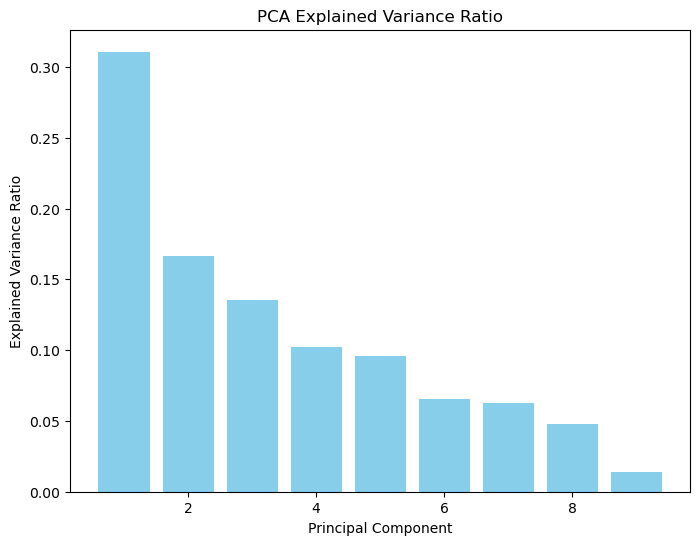

PCA Regression RMSE for each target:
{'3 Mo': 2.665529106069536, '2 Yr': 2.3618422395581544, '10 Yr': 1.778875249265985}


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define predictor and target columns
predictor_cols = ['GARCH_3Mo','GARCH_2Yr','GARCH_10Yr',
                  'PE_3Mo','PE_2Yr','PE_10Yr',
                  'HE_3Mo','HE_2Yr','HE_10Yr']
target_cols = ['3 Mo','2 Yr','10 Yr']

X = df_combined[predictor_cols]
y = df_combined[target_cols]

# Split data preserving time order (80/20 split)
split_index = int(0.8 * len(df_combined))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Standardize predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(8,6))
plt.bar(range(1,10), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

# Fit a linear regression model using the PCA components
lr = LinearRegression()
lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)

# Compute RMSE for each target
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("PCA Regression RMSE for each target:")
print(dict(zip(target_cols, rmse)))


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Random Forest using the same X_train_scaled, X_test_scaled, y_train, y_test
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf, multioutput='raw_values'))
print("Random Forest RMSE for each target:")
print(dict(zip(target_cols, rmse_rf)))


Random Forest RMSE for each target:
{'3 Mo': 1.288447773138139, '2 Yr': 0.9587365985359239, '10 Yr': 1.4536186696126843}


Epoch 1/100


c:\Users\npwol\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1241 - val_loss: 5.0934
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.8607 - val_loss: 4.7234
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.6929 - val_loss: 4.9606
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.6080 - val_loss: 4.8744
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.5591 - val_loss: 4.7416
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.5024 - val_loss: 4.5336
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.4890 - val_loss: 4.9985
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.4657 - val_loss: 4.7804
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.4455 - val_loss: 5.0985
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4404 - val_loss: 5.0758
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.4083 - val_loss: 4.9325
Epoch 12/100
168/168 ━━━━━━━━━━━━━━

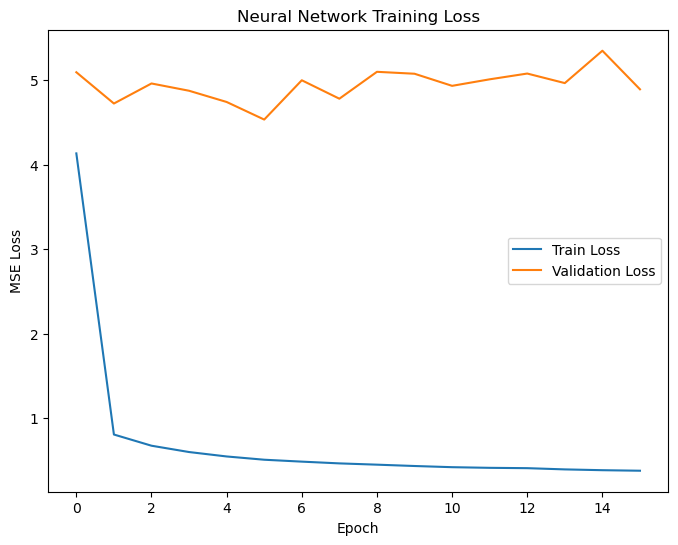

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Build a feed-forward neural network model
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3)  # Three outputs for 3 Mo, 2 Yr, 10 Yr yields
])
model_nn.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_nn = model_nn.fit(X_train_scaled, y_train, 
                          epochs=100, 
                          batch_size=32, 
                          validation_split=0.1,
                          callbacks=[early_stop],
                          verbose=1)

# Evaluate on test set
y_pred_nn = model_nn.predict(X_test_scaled)
rmse_nn = np.sqrt(np.mean((y_test - y_pred_nn)**2, axis=0))
print("Neural Network RMSE for each target:")
print(dict(zip(target_cols, rmse_nn)))

# Plot training history
plt.figure(figsize=(8,6))
plt.plot(history_nn.history['loss'], label='Train Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training Loss')
plt.legend()
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 64)    │        640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     66,368 │ dense_3[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 64)    │          0 │ dense_3[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10, 64)    │      4,160 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 64)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │         99 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,763 (303.76 KB)

 Trainable params: 77,763 (303.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 3.0116 - val_loss: 6.2527
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5080 - val_loss: 4.7558
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3968 - val_loss: 5.9135
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3042 - val_loss: 4.1452
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2492 - val_loss: 4.4058
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2063 - val_loss: 4.4704
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1698 - val_loss: 5.2650
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1566 - val_loss: 4.5002
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1270 - val_loss: 4.2965
Epoch 10/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1191 - val_loss: 5.0246
Epoch 11/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1014 - val_loss: 4.7432
Epoch 12/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

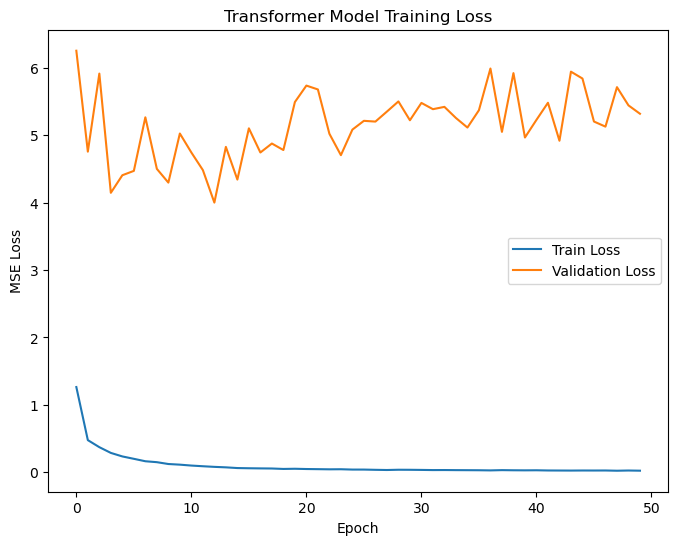

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set lookback window
lookback = 10

def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Use the standardized predictors and targets from df_combined
X_all = scaler.transform(X)  # Already scaled predictors
y_all = y.values

X_seq, y_seq = create_sequences(X_all, y_all, lookback)

# Split into training and test sets (80/20 split)
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

# Build a simple Transformer model
input_shape = X_train_seq.shape[1:]  # (lookback, number of predictors)

inputs = layers.Input(shape=input_shape)
# A simple Dense layer to project inputs to a higher dimension
x = layers.Dense(64, activation='relu')(inputs)

# Define a simple Transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = layers.Dense(ff_dim, activation="relu")(out1)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(3)(x)

model_trans = models.Model(inputs, outputs)
model_trans.compile(optimizer="adam", loss="mse")
model_trans.summary()

# Train the Transformer model
history_trans = model_trans.fit(X_train_seq, y_train_seq, 
                                epochs=50, 
                                batch_size=32, 
                                validation_split=0.1, 
                                verbose=1)

# Evaluate on test set
y_pred_trans = model_trans.predict(X_test_seq)
rmse_trans = np.sqrt(np.mean((y_test_seq - y_pred_trans)**2, axis=0))
print("Transformer RMSE for each target:")
print(dict(zip(target_cols, rmse_trans)))

# Plot training history for the Transformer model
plt.figure(figsize=(8,6))
plt.plot(history_trans.history['loss'], label='Train Loss')
plt.plot(history_trans.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Transformer Model Training Loss')
plt.legend()
plt.show()


PCA Regression (3 Mo) Classification Metrics:
Confusion Matrix:
[[685  61]
 [ 40 705]]
Accuracy: 0.932260228034876
ROC AUC: 0.9880004318333122


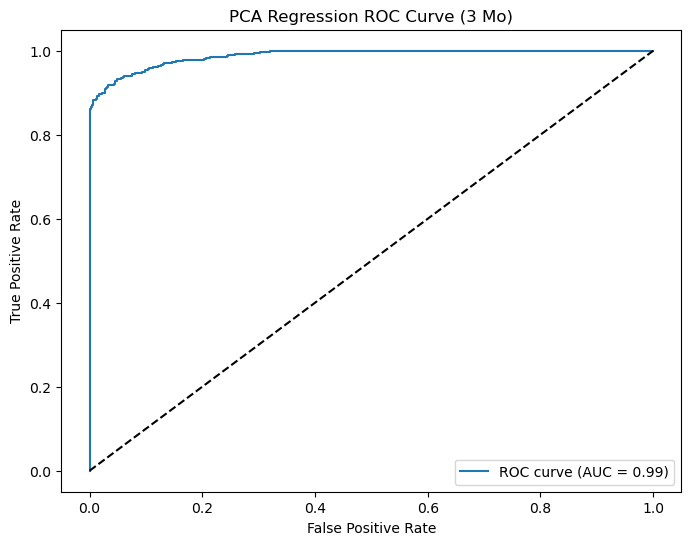

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Use the PCA regression predictions stored in y_pred from the PCA cell and the test targets y_test.
# For demonstration, we use the 3 Mo yield.
threshold_pca = np.median(y_test['3 Mo'])
y_test_bin = (y_test['3 Mo'] > threshold_pca).astype(int)
y_pred_pca_bin = (y_pred[:, 0] > threshold_pca).astype(int)

# Compute confusion matrix and accuracy
cm_pca = confusion_matrix(y_test_bin, y_pred_pca_bin)
accuracy_pca = accuracy_score(y_test_bin, y_pred_pca_bin)
fpr_pca, tpr_pca, _ = roc_curve(y_test_bin, y_pred[:, 0])
roc_auc_pca = auc(fpr_pca, tpr_pca)

print("PCA Regression (3 Mo) Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca)
print("Accuracy:", accuracy_pca)
print("ROC AUC:", roc_auc_pca)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca, tpr_pca, label=f'ROC curve (AUC = {roc_auc_pca:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (3 Mo)')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix (Random Forest, 3 Mo):
[[721  25]
 [151 594]]
Accuracy: 0.8819584171696848
ROC AUC (Random Forest, 3 Mo): 0.9720531874696368


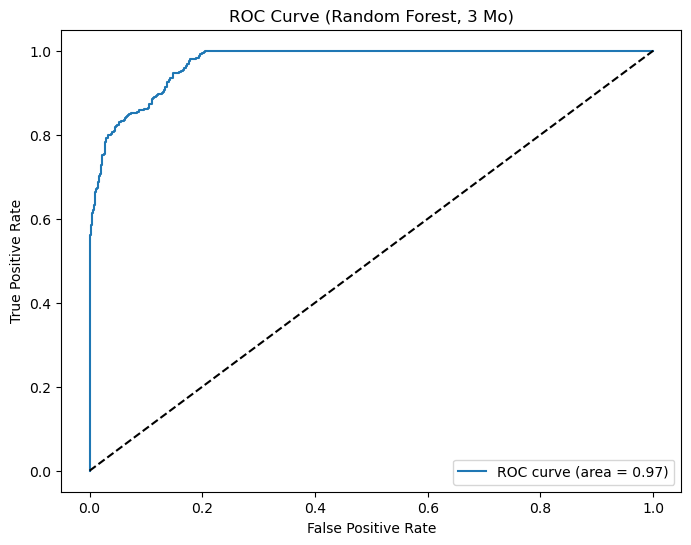

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

# For demonstration, use the Random Forest predictions for the 3 Mo yield
# Define threshold as the median of the actual 3 Mo yields in the test set.
threshold = np.median(y_test['3 Mo'])

# Convert continuous targets and predictions to binary labels:
# 1 if yield > threshold (e.g., high regime), 0 otherwise.
y_test_bin = (y_test['3 Mo'] > threshold).astype(int)
y_pred_rf_bin = (y_pred_rf[:, 0] > threshold).astype(int)

# Compute confusion matrix and accuracy
cm = confusion_matrix(y_test_bin, y_pred_rf_bin)
accuracy = accuracy_score(y_test_bin, y_pred_rf_bin)
print("Confusion Matrix (Random Forest, 3 Mo):")
print(cm)
print("Accuracy:", accuracy)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_rf[:, 0])
roc_auc = auc(fpr, tpr)
print("ROC AUC (Random Forest, 3 Mo):", roc_auc)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest, 3 Mo)')
plt.legend(loc='lower right')
plt.show()


Neural Network Regression (3 Mo) Classification Metrics:
Confusion Matrix:
[[693  53]
 [ 83 662]]
Accuracy: 0.9087860496311201
ROC AUC: 0.9749518685787285


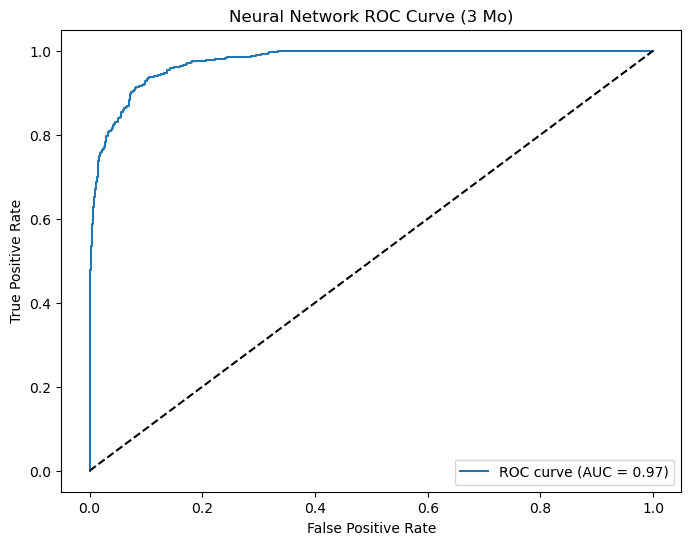

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Using predictions from the Neural Network (y_pred_nn) and the same y_test as before:
threshold_nn = np.median(y_test['3 Mo'])
y_test_bin = (y_test['3 Mo'] > threshold_nn).astype(int)
y_pred_nn_bin = (y_pred_nn[:, 0] > threshold_nn).astype(int)

# Compute confusion matrix and accuracy
cm_nn = confusion_matrix(y_test_bin, y_pred_nn_bin)
accuracy_nn = accuracy_score(y_test_bin, y_pred_nn_bin)
fpr_nn, tpr_nn, _ = roc_curve(y_test_bin, y_pred_nn[:, 0])
roc_auc_nn = auc(fpr_nn, tpr_nn)

print("Neural Network Regression (3 Mo) Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn)
print("Accuracy:", accuracy_nn)
print("ROC AUC:", roc_auc_nn)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn, tpr_nn, label=f'ROC curve (AUC = {roc_auc_nn:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (3 Mo)')
plt.legend(loc='lower right')
plt.show()


Transformer Regression (3 Mo) Classification Metrics:
Confusion Matrix:
[[683  63]
 [111 632]]
Accuracy: 0.8831430490261921
ROC AUC: 0.9656706562410919


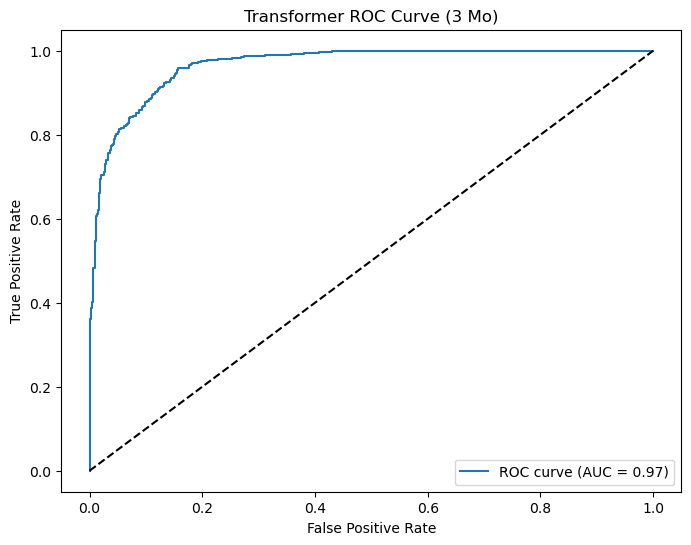

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For the Transformer model, our test set is based on sequences.
# We use y_test_seq and y_pred_trans (both are numpy arrays). 
# Here, we focus on the first output (3 Mo yield).
threshold_trans = np.median(y_test_seq[:, 0])
y_test_trans_bin = (y_test_seq[:, 0] > threshold_trans).astype(int)
y_pred_trans_bin = (y_pred_trans[:, 0] > threshold_trans).astype(int)

# Compute confusion matrix and accuracy
cm_trans = confusion_matrix(y_test_trans_bin, y_pred_trans_bin)
accuracy_trans = accuracy_score(y_test_trans_bin, y_pred_trans_bin)
fpr_trans, tpr_trans, _ = roc_curve(y_test_trans_bin, y_pred_trans[:, 0])
roc_auc_trans = auc(fpr_trans, tpr_trans)

print("Transformer Regression (3 Mo) Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans)
print("Accuracy:", accuracy_trans)
print("ROC AUC:", roc_auc_trans)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans, tpr_trans, label=f'ROC curve (AUC = {roc_auc_trans:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (3 Mo)')
plt.legend(loc='lower right')
plt.show()


PCA Regression (2 Yr) Classification Metrics:
Confusion Matrix:
[[643 106]
 [ 41 701]]
Accuracy: 0.9014084507042254
ROC AUC: 0.9631746191687749


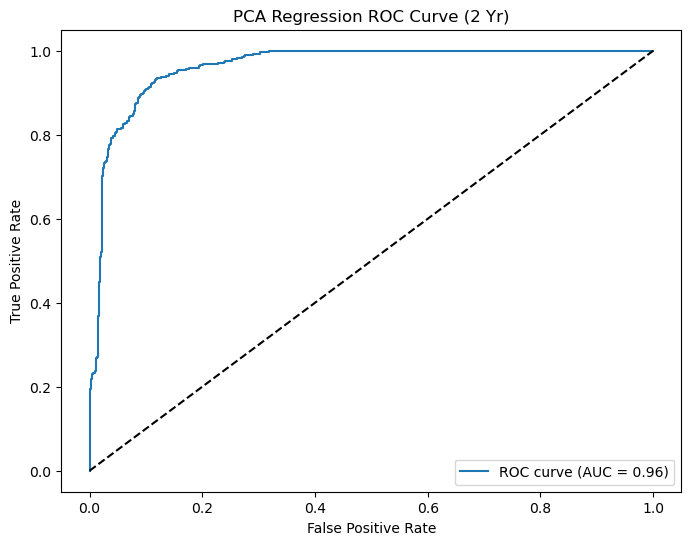

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For PCA regression, we use y_pred from the PCA cell.
# Use the 2 Yr yield (column '2 Yr') from y_test and y_pred.
threshold_pca_2yr = np.median(y_test['2 Yr'])
y_test_bin_2yr = (y_test['2 Yr'] > threshold_pca_2yr).astype(int)
y_pred_pca_bin_2yr = (y_pred[:, 1] > threshold_pca_2yr).astype(int)

cm_pca_2yr = confusion_matrix(y_test_bin_2yr, y_pred_pca_bin_2yr)
accuracy_pca_2yr = accuracy_score(y_test_bin_2yr, y_pred_pca_bin_2yr)
fpr_pca_2yr, tpr_pca_2yr, _ = roc_curve(y_test_bin_2yr, y_pred[:, 1])
roc_auc_pca_2yr = auc(fpr_pca_2yr, tpr_pca_2yr)

print("PCA Regression (2 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_2yr)
print("Accuracy:", accuracy_pca_2yr)
print("ROC AUC:", roc_auc_pca_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_2yr, tpr_pca_2yr, label=f'ROC curve (AUC = {roc_auc_pca_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (2 Yr)')
plt.legend(loc='lower right')
plt.show()


Random Forest Regression (2 Yr) Classification Metrics:
Confusion Matrix:
[[677  72]
 [124 618]]
Accuracy: 0.8685446009389671
ROC AUC: 0.9469382357069083


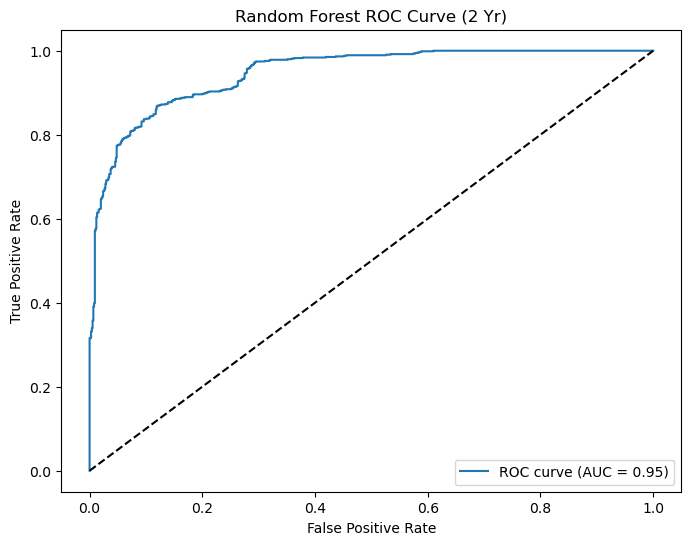

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Using Random Forest predictions stored in y_pred_rf; column index 1 corresponds to 2 Yr.
threshold_rf_2yr = np.median(y_test['2 Yr'])
y_test_bin_rf_2yr = (y_test['2 Yr'] > threshold_rf_2yr).astype(int)
y_pred_rf_bin_2yr = (y_pred_rf[:, 1] > threshold_rf_2yr).astype(int)

cm_rf_2yr = confusion_matrix(y_test_bin_rf_2yr, y_pred_rf_bin_2yr)
accuracy_rf_2yr = accuracy_score(y_test_bin_rf_2yr, y_pred_rf_bin_2yr)
fpr_rf_2yr, tpr_rf_2yr, _ = roc_curve(y_test_bin_rf_2yr, y_pred_rf[:, 1])
roc_auc_rf_2yr = auc(fpr_rf_2yr, tpr_rf_2yr)

print("Random Forest Regression (2 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_2yr)
print("Accuracy:", accuracy_rf_2yr)
print("ROC AUC:", roc_auc_rf_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_2yr, tpr_rf_2yr, label=f'ROC curve (AUC = {roc_auc_rf_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (2 Yr)')
plt.legend(loc='lower right')
plt.show()


Neural Network Regression (2 Yr) Classification Metrics:
Confusion Matrix:
[[645 104]
 [ 47 695]]
Accuracy: 0.8987256874580818
ROC AUC: 0.9540375487172473


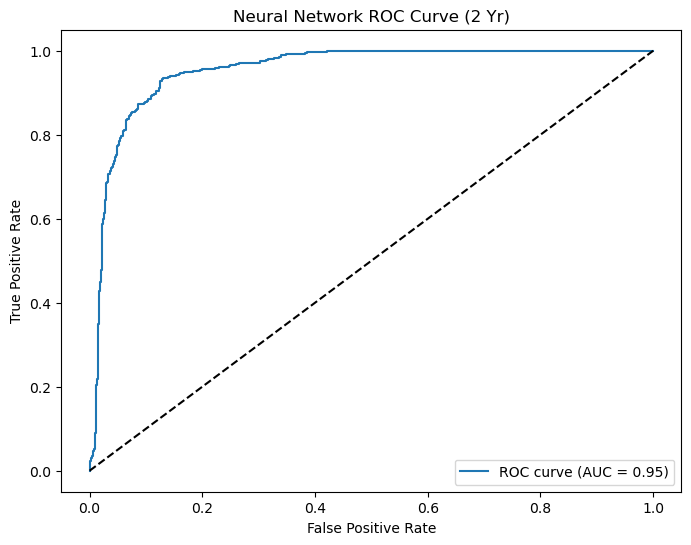

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Using Neural Network predictions stored in y_pred_nn; column index 1 corresponds to 2 Yr.
threshold_nn_2yr = np.median(y_test['2 Yr'])
y_test_bin_nn_2yr = (y_test['2 Yr'] > threshold_nn_2yr).astype(int)
y_pred_nn_bin_2yr = (y_pred_nn[:, 1] > threshold_nn_2yr).astype(int)

cm_nn_2yr = confusion_matrix(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
accuracy_nn_2yr = accuracy_score(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
fpr_nn_2yr, tpr_nn_2yr, _ = roc_curve(y_test_bin_nn_2yr, y_pred_nn[:, 1])
roc_auc_nn_2yr = auc(fpr_nn_2yr, tpr_nn_2yr)

print("Neural Network Regression (2 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_2yr)
print("Accuracy:", accuracy_nn_2yr)
print("ROC AUC:", roc_auc_nn_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_2yr, tpr_nn_2yr, label=f'ROC curve (AUC = {roc_auc_nn_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (2 Yr)')
plt.legend(loc='lower right')
plt.show()


Neural Network Regression (2 Yr) Classification Metrics:
Confusion Matrix:
[[645 104]
 [ 47 695]]
Accuracy: 0.8987256874580818
ROC AUC: 0.9540375487172473


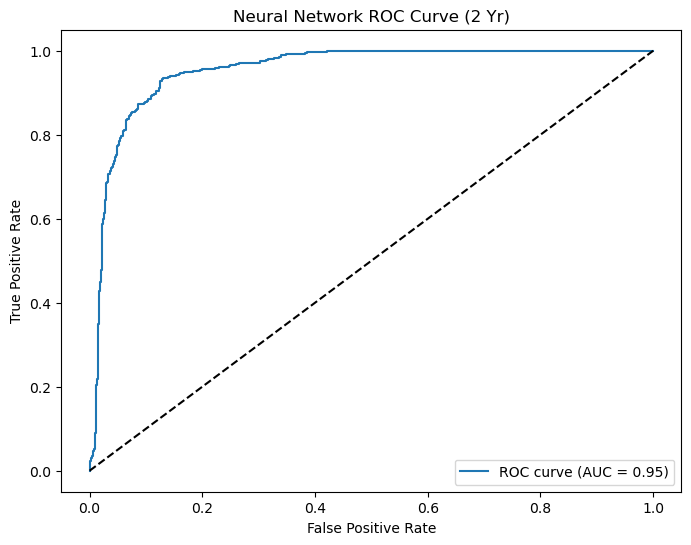

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Using Neural Network predictions stored in y_pred_nn; column index 1 corresponds to 2 Yr.
threshold_nn_2yr = np.median(y_test['2 Yr'])
y_test_bin_nn_2yr = (y_test['2 Yr'] > threshold_nn_2yr).astype(int)
y_pred_nn_bin_2yr = (y_pred_nn[:, 1] > threshold_nn_2yr).astype(int)

cm_nn_2yr = confusion_matrix(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
accuracy_nn_2yr = accuracy_score(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
fpr_nn_2yr, tpr_nn_2yr, _ = roc_curve(y_test_bin_nn_2yr, y_pred_nn[:, 1])
roc_auc_nn_2yr = auc(fpr_nn_2yr, tpr_nn_2yr)

print("Neural Network Regression (2 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_2yr)
print("Accuracy:", accuracy_nn_2yr)
print("ROC AUC:", roc_auc_nn_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_2yr, tpr_nn_2yr, label=f'ROC curve (AUC = {roc_auc_nn_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (2 Yr)')
plt.legend(loc='lower right')
plt.show()


Transformer Regression (2 Yr) Classification Metrics:
Confusion Matrix:
[[675  74]
 [101 639]]
Accuracy: 0.8824714573539288
ROC AUC: 0.9487460758488796


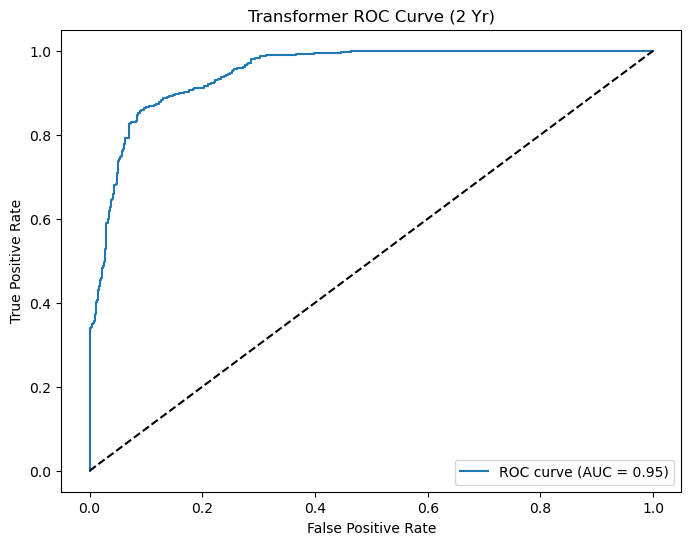

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For the Transformer model, use y_test_seq and y_pred_trans.
# Column index 1 corresponds to 2 Yr yield.
threshold_trans_2yr = np.median(y_test_seq[:, 1])
y_test_trans_bin_2yr = (y_test_seq[:, 1] > threshold_trans_2yr).astype(int)
y_pred_trans_bin_2yr = (y_pred_trans[:, 1] > threshold_trans_2yr).astype(int)

cm_trans_2yr = confusion_matrix(y_test_trans_bin_2yr, y_pred_trans_bin_2yr)
accuracy_trans_2yr = accuracy_score(y_test_trans_bin_2yr, y_pred_trans_bin_2yr)
fpr_trans_2yr, tpr_trans_2yr, _ = roc_curve(y_test_trans_bin_2yr, y_pred_trans[:, 1])
roc_auc_trans_2yr = auc(fpr_trans_2yr, tpr_trans_2yr)

print("Transformer Regression (2 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_2yr)
print("Accuracy:", accuracy_trans_2yr)
print("ROC AUC:", roc_auc_trans_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_2yr, tpr_trans_2yr, label=f'ROC curve (AUC = {roc_auc_trans_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (2 Yr)')
plt.legend(loc='lower right')
plt.show()


PCA Regression (10 Yr) Classification Metrics:
Confusion Matrix:
[[558 189]
 [  9 735]]
Accuracy: 0.8672032193158954
ROC AUC: 0.9506898561989895


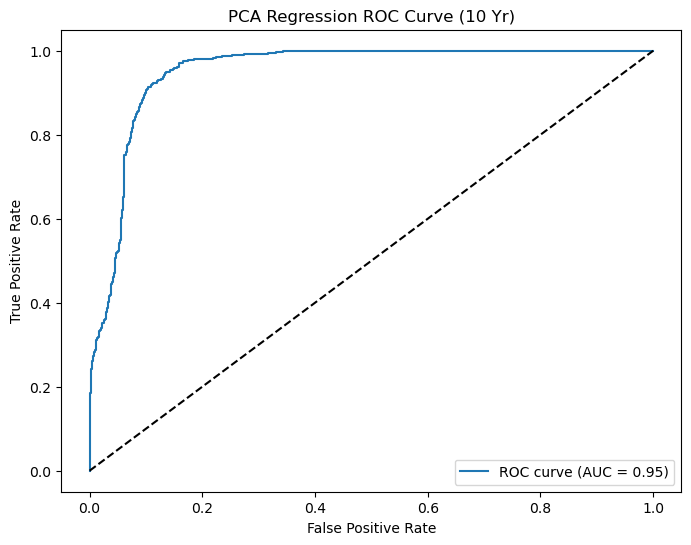

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For PCA regression, use y_pred from the PCA cell.
# Use the 10 Yr yield (column '10 Yr') from y_test and y_pred.
threshold_pca_10yr = np.median(y_test['10 Yr'])
y_test_bin_10yr = (y_test['10 Yr'] > threshold_pca_10yr).astype(int)
y_pred_pca_bin_10yr = (y_pred[:, 2] > threshold_pca_10yr).astype(int)

cm_pca_10yr = confusion_matrix(y_test_bin_10yr, y_pred_pca_bin_10yr)
accuracy_pca_10yr = accuracy_score(y_test_bin_10yr, y_pred_pca_bin_10yr)
fpr_pca_10yr, tpr_pca_10yr, _ = roc_curve(y_test_bin_10yr, y_pred[:, 2])
roc_auc_pca_10yr = auc(fpr_pca_10yr, tpr_pca_10yr)

print("PCA Regression (10 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_10yr)
print("Accuracy:", accuracy_pca_10yr)
print("ROC AUC:", roc_auc_pca_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_10yr, tpr_pca_10yr, label=f'ROC curve (AUC = {roc_auc_pca_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (10 Yr)')
plt.legend(loc='lower right')
plt.show()


Random Forest Regression (10 Yr) Classification Metrics:
Confusion Matrix:
[[200 547]
 [ 27 717]]
Accuracy: 0.6150234741784038
ROC AUC: 0.8894178866001641


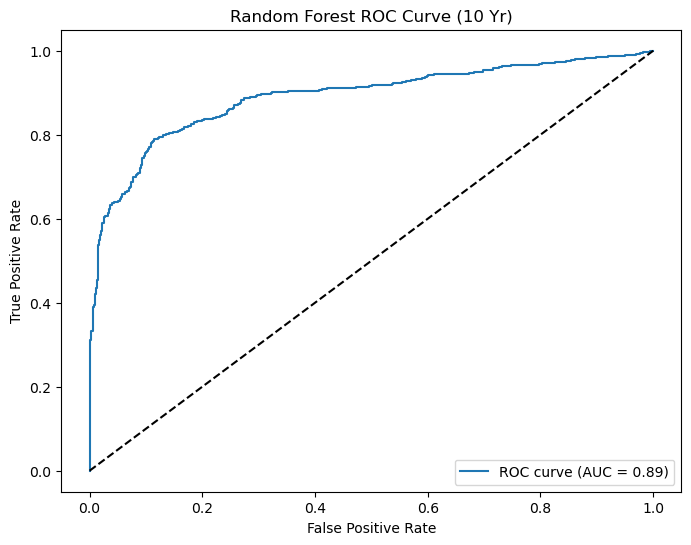

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Using Random Forest predictions stored in y_pred_rf; column index 2 corresponds to 10 Yr.
threshold_rf_10yr = np.median(y_test['10 Yr'])
y_test_bin_rf_10yr = (y_test['10 Yr'] > threshold_rf_10yr).astype(int)
y_pred_rf_bin_10yr = (y_pred_rf[:, 2] > threshold_rf_10yr).astype(int)

cm_rf_10yr = confusion_matrix(y_test_bin_rf_10yr, y_pred_rf_bin_10yr)
accuracy_rf_10yr = accuracy_score(y_test_bin_rf_10yr, y_pred_rf_bin_10yr)
fpr_rf_10yr, tpr_rf_10yr, _ = roc_curve(y_test_bin_rf_10yr, y_pred_rf[:, 2])
roc_auc_rf_10yr = auc(fpr_rf_10yr, tpr_rf_10yr)

print("Random Forest Regression (10 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_10yr)
print("Accuracy:", accuracy_rf_10yr)
print("ROC AUC:", roc_auc_rf_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_10yr, tpr_rf_10yr, label=f'ROC curve (AUC = {roc_auc_rf_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (10 Yr)')
plt.legend(loc='lower right')
plt.show()


Neural Network Regression (10 Yr) Classification Metrics:
Confusion Matrix:
[[302 445]
 [ 13 731]]
Accuracy: 0.6928236083165661
ROC AUC: 0.9185307538397317


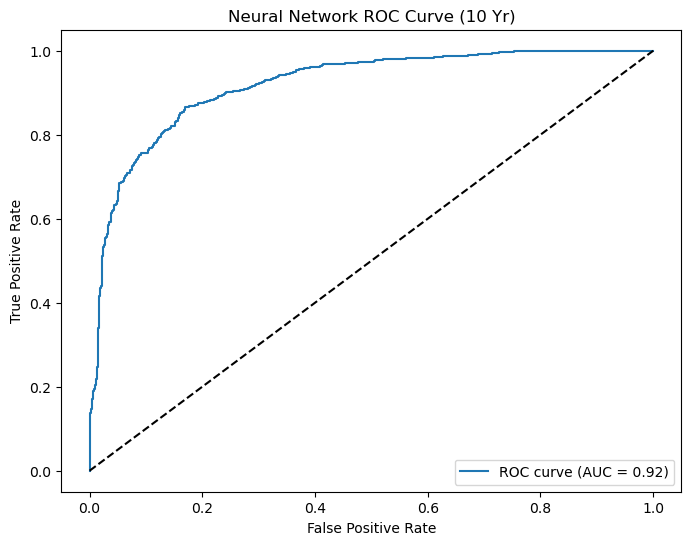

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Using Neural Network predictions stored in y_pred_nn; column index 2 corresponds to 10 Yr.
threshold_nn_10yr = np.median(y_test['10 Yr'])
y_test_bin_nn_10yr = (y_test['10 Yr'] > threshold_nn_10yr).astype(int)
y_pred_nn_bin_10yr = (y_pred_nn[:, 2] > threshold_nn_10yr).astype(int)

cm_nn_10yr = confusion_matrix(y_test_bin_nn_10yr, y_pred_nn_bin_10yr)
accuracy_nn_10yr = accuracy_score(y_test_bin_nn_10yr, y_pred_nn_bin_10yr)
fpr_nn_10yr, tpr_nn_10yr, _ = roc_curve(y_test_bin_nn_10yr, y_pred_nn[:, 2])
roc_auc_nn_10yr = auc(fpr_nn_10yr, tpr_nn_10yr)

print("Neural Network Regression (10 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_10yr)
print("Accuracy:", accuracy_nn_10yr)
print("ROC AUC:", roc_auc_nn_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_10yr, tpr_nn_10yr, label=f'ROC curve (AUC = {roc_auc_nn_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (10 Yr)')
plt.legend(loc='lower right')
plt.show()


Transformer Regression (10 Yr) Classification Metrics:
Confusion Matrix:
[[314 433]
 [ 23 719]]
Accuracy: 0.6937541974479516
ROC AUC: 0.9414838148641287


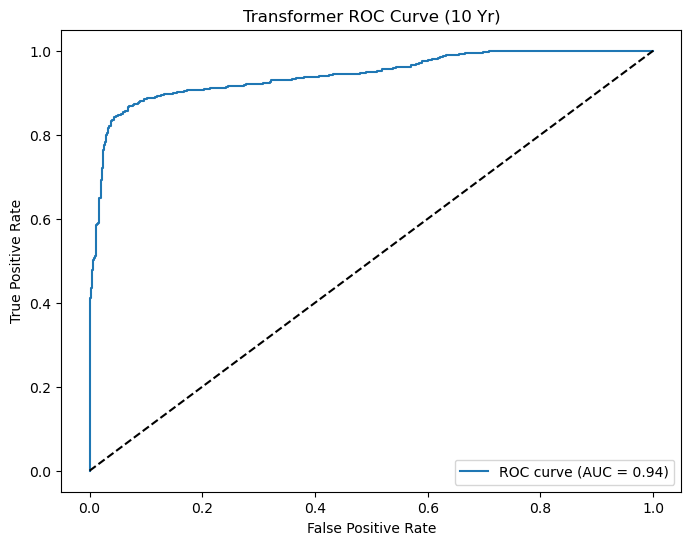

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For the Transformer model, use y_test_seq and y_pred_trans.
# Column index 2 corresponds to the 10 Yr yield.
threshold_trans_10yr = np.median(y_test_seq[:, 2])
y_test_trans_bin_10yr = (y_test_seq[:, 2] > threshold_trans_10yr).astype(int)
y_pred_trans_bin_10yr = (y_pred_trans[:, 2] > threshold_trans_10yr).astype(int)

cm_trans_10yr = confusion_matrix(y_test_trans_bin_10yr, y_pred_trans_bin_10yr)
accuracy_trans_10yr = accuracy_score(y_test_trans_bin_10yr, y_pred_trans_bin_10yr)
fpr_trans_10yr, tpr_trans_10yr, _ = roc_curve(y_test_trans_bin_10yr, y_pred_trans[:, 2])
roc_auc_trans_10yr = auc(fpr_trans_10yr, tpr_trans_10yr)

print("Transformer Regression (10 Yr) Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_10yr)
print("Accuracy:", accuracy_trans_10yr)
print("ROC AUC:", roc_auc_trans_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_10yr, tpr_trans_10yr, label=f'ROC curve (AUC = {roc_auc_trans_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (10 Yr)')
plt.legend(loc='lower right')
plt.show()


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras import Model

# Helper functions to create sequences
def create_sequences_flat(X_df, y_series, window):
    """Creates 2D sequences (flattened) for PCA, RF, and NN.
    Returns X of shape (n_samples, window * num_features) and y of shape (n_samples,)."""
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values.flatten())
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

def create_sequences_transformer(X_df, y_series, window):
    """Creates 3D sequences for the transformer.
    Returns X of shape (n_samples, window, num_features) and y of shape (n_samples,)."""
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values)
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

# Parameters
window = 30

# For 3‑Mo yield, predictors come from the corresponding columns in df_combined.
df_pred_3mo = df_combined[['GARCH_3Mo', 'PE_3Mo', 'HE_3Mo']]
target_3mo = df_combined['3 Mo']

# Create sequences for flat models (PCA, Random Forest, Neural Network)
X_flat_3mo, y_flat_3mo = create_sequences_flat(df_pred_3mo, target_3mo, window)
# Create sequences for the Transformer (keeping time structure)
X_seq_3mo, y_seq_3mo = create_sequences_transformer(df_pred_3mo, target_3mo, window)

# Split into training and test sets (preserving time order)
split_idx = int(0.8 * len(X_flat_3mo))
X_train_flat, X_test_flat = X_flat_3mo[:split_idx], X_flat_3mo[split_idx:]
y_train, y_test = y_flat_3mo[:split_idx], y_flat_3mo[split_idx:]

X_train_seq, X_test_seq = X_seq_3mo[:split_idx], X_seq_3mo[split_idx:]
y_train_seq, y_test_seq = y_seq_3mo[:split_idx], y_seq_3mo[split_idx:]

# Standardize the flat predictors
scaler_3mo = StandardScaler()
X_train_flat_scaled = scaler_3mo.fit_transform(X_train_flat)
X_test_flat_scaled = scaler_3mo.transform(X_test_flat)

#### PCA Regression Model for 3 Mo ####
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_flat_scaled)
X_test_pca = pca.transform(X_test_flat_scaled)

lr = LinearRegression()
lr.fit(X_train_pca, y_train)
y_pred_pca = lr.predict(X_test_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
print("3 Mo - PCA Regression RMSE:", rmse_pca)

#### Random Forest Model for 3 Mo ####
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_flat_scaled, y_train)
y_pred_rf = rf.predict(X_test_flat_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("3 Mo - Random Forest RMSE:", rmse_rf)

#### Neural Network Model for 3 Mo ####
model_nn_3mo = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flat_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_nn_3mo.compile(optimizer='adam', loss='mse')
history_nn_3mo = model_nn_3mo.fit(X_train_flat_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_nn = model_nn_3mo.predict(X_test_flat_scaled).flatten()
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("3 Mo - Neural Network RMSE:", rmse_nn)

#### Transformer Model for 3 Mo ####
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

input_shape = X_train_seq.shape[1:]  # (window, num_features) = (30, 3)
inputs = Input(shape=input_shape)
x = Dense(64, activation='relu')(inputs)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)
model_trans_3mo = Model(inputs, outputs)
model_trans_3mo.compile(optimizer="adam", loss="mse")
model_trans_3mo.summary()

history_trans_3mo = model_trans_3mo.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_trans = model_trans_3mo.predict(X_test_seq).flatten()
rmse_trans = np.sqrt(mean_squared_error(y_test_seq, y_pred_trans))
print("3 Mo - Transformer RMSE:", rmse_trans)


3 Mo - PCA Regression RMSE: 1.8727173328504705
3 Mo - Random Forest RMSE: 0.9985667935589753


c:\Users\npwol\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3 Mo - Neural Network RMSE: 1.597233285092129


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 30, 64)    │        256 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ dense_11[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 64)    │          0 │ dense_11[0][0],   │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 30, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 30, 64)    │      4,160 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 64)    │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         33 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,313 (302.00 KB)

 Trainable params: 77,313 (302.00 KB)

 Non-trainable params: 0 (0.00 B)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3 Mo - Transformer RMSE: 1.2168641675519511


Defining y_test_3mo and related variables from forecasting results...
3 Mo - PCA Regression Classification Metrics:
Confusion Matrix:
[[419 327]
 [105 634]]
Accuracy: 0.7090909090909091
ROC AUC: 0.8257100567029572


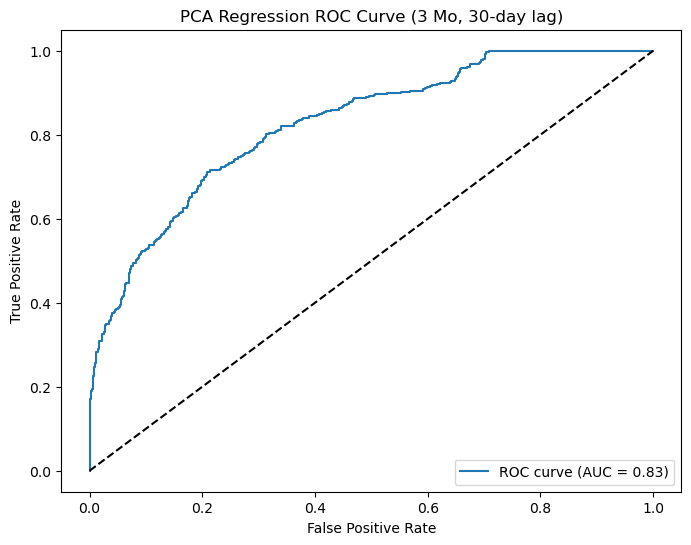

3 Mo - Random Forest Regression Classification Metrics:
Confusion Matrix:
[[656  90]
 [ 63 676]]
Accuracy: 0.896969696969697
ROC AUC: 0.9776090434505001


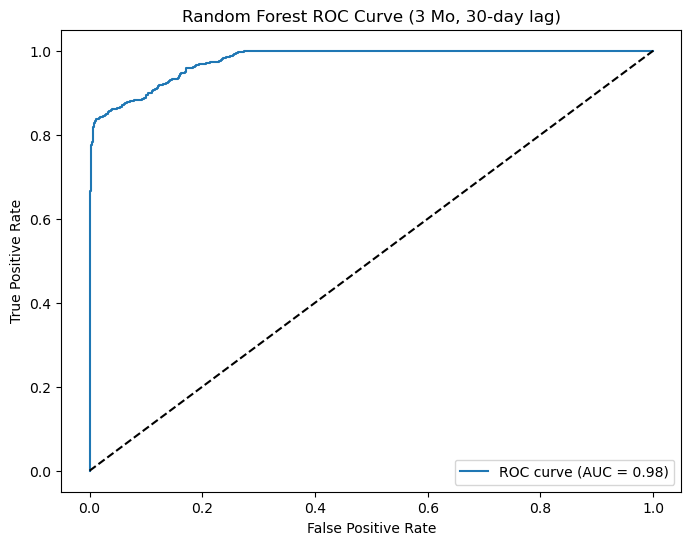

3 Mo - Neural Network Regression Classification Metrics:
Confusion Matrix:
[[643 103]
 [138 601]]
Accuracy: 0.8377104377104377
ROC AUC: 0.9126346377794787


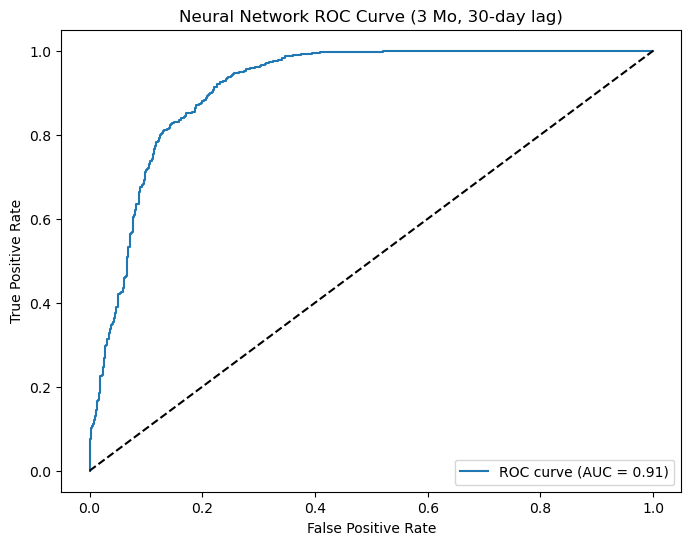

3 Mo - Transformer Regression Classification Metrics:
Confusion Matrix:
[[661  85]
 [ 77 662]]
Accuracy: 0.8909090909090909
ROC AUC: 0.9694954053554001


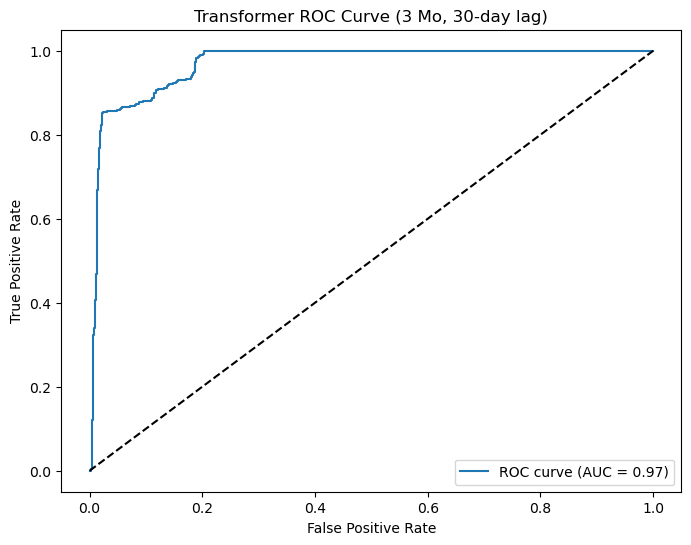

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

# If your forecasting cell used different variable names, set aliases here.
# For example, if your forecasting cell defined:
#   y_test (for flat predictions) and y_test_seq (for transformer),
#   y_pred_pca, y_pred_rf, y_pred_nn, and y_pred_trans,
# then we set:
try:
    y_test_3mo
except NameError:
    print("Defining y_test_3mo and related variables from forecasting results...")
    y_test_3mo = y_test        # y_test from the forecasting cell for 3 Mo (flat model)
    y_pred_pca_3mo = y_pred_pca  # PCA regression predictions for 3 Mo
    y_pred_rf_3mo = y_pred_rf    # Random Forest predictions for 3 Mo
    y_pred_nn_3mo = y_pred_nn    # Neural Network predictions for 3 Mo
    y_test_seq_3mo = y_test_seq  # Transformer test targets (3 Mo, sequence version)
    y_pred_trans_3mo = y_pred_trans  # Transformer predictions for 3 Mo

# --- PCA Regression (3 Mo) Classification Metrics ---
threshold_3mo = np.median(y_test_3mo)
y_test_bin_3mo = (y_test_3mo > threshold_3mo).astype(int)
y_pred_pca_bin_3mo = (y_pred_pca_3mo > threshold_3mo).astype(int)

cm_pca_3mo = confusion_matrix(y_test_bin_3mo, y_pred_pca_bin_3mo)
accuracy_pca_3mo = accuracy_score(y_test_bin_3mo, y_pred_pca_bin_3mo)
fpr_pca_3mo, tpr_pca_3mo, _ = roc_curve(y_test_bin_3mo, y_pred_pca_3mo)
roc_auc_pca_3mo = auc(fpr_pca_3mo, tpr_pca_3mo)

print("3 Mo - PCA Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_3mo)
print("Accuracy:", accuracy_pca_3mo)
print("ROC AUC:", roc_auc_pca_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_3mo, tpr_pca_3mo, label=f'ROC curve (AUC = {roc_auc_pca_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

# --- Random Forest Regression (3 Mo) Classification Metrics ---
threshold_rf_3mo = np.median(y_test_3mo)
y_test_bin_rf_3mo = (y_test_3mo > threshold_rf_3mo).astype(int)
y_pred_rf_bin_3mo = (y_pred_rf_3mo > threshold_rf_3mo).astype(int)

cm_rf_3mo = confusion_matrix(y_test_bin_rf_3mo, y_pred_rf_bin_3mo)
accuracy_rf_3mo = accuracy_score(y_test_bin_rf_3mo, y_pred_rf_bin_3mo)
fpr_rf_3mo, tpr_rf_3mo, _ = roc_curve(y_test_bin_rf_3mo, y_pred_rf_3mo)
roc_auc_rf_3mo = auc(fpr_rf_3mo, tpr_rf_3mo)

print("3 Mo - Random Forest Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_3mo)
print("Accuracy:", accuracy_rf_3mo)
print("ROC AUC:", roc_auc_rf_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_3mo, tpr_rf_3mo, label=f'ROC curve (AUC = {roc_auc_rf_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

# --- Neural Network Regression (3 Mo) Classification Metrics ---
threshold_nn_3mo = np.median(y_test_3mo)
y_test_bin_nn_3mo = (y_test_3mo > threshold_nn_3mo).astype(int)
y_pred_nn_bin_3mo = (y_pred_nn_3mo > threshold_nn_3mo).astype(int)

cm_nn_3mo = confusion_matrix(y_test_bin_nn_3mo, y_pred_nn_bin_3mo)
accuracy_nn_3mo = accuracy_score(y_test_bin_nn_3mo, y_pred_nn_bin_3mo)
fpr_nn_3mo, tpr_nn_3mo, _ = roc_curve(y_test_bin_nn_3mo, y_pred_nn_3mo)
roc_auc_nn_3mo = auc(fpr_nn_3mo, tpr_nn_3mo)

print("3 Mo - Neural Network Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_3mo)
print("Accuracy:", accuracy_nn_3mo)
print("ROC AUC:", roc_auc_nn_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_3mo, tpr_nn_3mo, label=f'ROC curve (AUC = {roc_auc_nn_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

# --- Transformer Regression (3 Mo) Classification Metrics ---
threshold_trans_3mo = np.median(y_test_seq_3mo)
y_test_bin_trans_3mo = (y_test_seq_3mo > threshold_trans_3mo).astype(int)
y_pred_trans_bin_3mo = (y_pred_trans_3mo > threshold_trans_3mo).astype(int)

cm_trans_3mo = confusion_matrix(y_test_bin_trans_3mo, y_pred_trans_bin_3mo)
accuracy_trans_3mo = accuracy_score(y_test_bin_trans_3mo, y_pred_trans_bin_3mo)
fpr_trans_3mo, tpr_trans_3mo, _ = roc_curve(y_test_bin_trans_3mo, y_pred_trans_3mo)
roc_auc_trans_3mo = auc(fpr_trans_3mo, tpr_trans_3mo)

print("3 Mo - Transformer Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_3mo)
print("Accuracy:", accuracy_trans_3mo)
print("ROC AUC:", roc_auc_trans_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_3mo, tpr_trans_3mo, label=f'ROC curve (AUC = {roc_auc_trans_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


In [71]:
# Cell for 2 Yr Forecasting using 30-day lagged values of GARCH_2Yr, PE_2Yr, and HE_2Yr

def create_sequences_flat(X_df, y_series, window):
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values.flatten())
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

def create_sequences_transformer(X_df, y_series, window):
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values)
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

window = 30
df_pred_2yr = df_combined[['GARCH_2Yr', 'PE_2Yr', 'HE_2Yr']]
target_2yr = df_combined['2 Yr']

X_flat_2yr, y_flat_2yr = create_sequences_flat(df_pred_2yr, target_2yr, window)
X_seq_2yr, y_seq_2yr = create_sequences_transformer(df_pred_2yr, target_2yr, window)

split_idx = int(0.8 * len(X_flat_2yr))
X_train_flat_2yr, X_test_flat_2yr = X_flat_2yr[:split_idx], X_flat_2yr[split_idx:]
y_train_2yr, y_test_2yr = y_flat_2yr[:split_idx], y_flat_2yr[split_idx:]

X_train_seq_2yr, X_test_seq_2yr = X_seq_2yr[:split_idx], X_seq_2yr[split_idx:]
y_train_seq_2yr, y_test_seq_2yr = y_seq_2yr[:split_idx], y_seq_2yr[split_idx:]

scaler_2yr = StandardScaler()
X_train_flat_2yr_scaled = scaler_2yr.fit_transform(X_train_flat_2yr)
X_test_flat_2yr_scaled = scaler_2yr.transform(X_test_flat_2yr)

#### PCA Regression for 2 Yr ####
pca_2yr = PCA(n_components=10)
X_train_pca_2yr = pca_2yr.fit_transform(X_train_flat_2yr_scaled)
X_test_pca_2yr = pca_2yr.transform(X_test_flat_2yr_scaled)
lr_2yr = LinearRegression()
lr_2yr.fit(X_train_pca_2yr, y_train_2yr)
y_pred_pca_2yr = lr_2yr.predict(X_test_pca_2yr)
rmse_pca_2yr = np.sqrt(mean_squared_error(y_test_2yr, y_pred_pca_2yr))
print("2 Yr - PCA Regression RMSE:", rmse_pca_2yr)

#### Random Forest for 2 Yr ####
rf_2yr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_2yr.fit(X_train_flat_2yr_scaled, y_train_2yr)
y_pred_rf_2yr = rf_2yr.predict(X_test_flat_2yr_scaled)
rmse_rf_2yr = np.sqrt(mean_squared_error(y_test_2yr, y_pred_rf_2yr))
print("2 Yr - Random Forest RMSE:", rmse_rf_2yr)

#### Neural Network for 2 Yr ####
model_nn_2yr = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flat_2yr_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_nn_2yr.compile(optimizer='adam', loss='mse')
history_nn_2yr = model_nn_2yr.fit(X_train_flat_2yr_scaled, y_train_2yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_nn_2yr = model_nn_2yr.predict(X_test_flat_2yr_scaled).flatten()
rmse_nn_2yr = np.sqrt(mean_squared_error(y_test_2yr, y_pred_nn_2yr))
print("2 Yr - Neural Network RMSE:", rmse_nn_2yr)

#### Transformer for 2 Yr ####
input_shape_2yr = X_train_seq_2yr.shape[1:]  # (window, num_features) = (30, 3)
inputs_2yr = Input(shape=input_shape_2yr)
x_2yr = Dense(64, activation='relu')(inputs_2yr)
x_2yr = transformer_encoder(x_2yr, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x_2yr = GlobalAveragePooling1D()(x_2yr)
x_2yr = Dense(32, activation='relu')(x_2yr)
outputs_2yr = Dense(1)(x_2yr)
model_trans_2yr = Model(inputs_2yr, outputs_2yr)
model_trans_2yr.compile(optimizer="adam", loss="mse")
model_trans_2yr.summary()
history_trans_2yr = model_trans_2yr.fit(X_train_seq_2yr, y_train_seq_2yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_trans_2yr = model_trans_2yr.predict(X_test_seq_2yr).flatten()
rmse_trans_2yr = np.sqrt(mean_squared_error(y_test_seq_2yr, y_pred_trans_2yr))
print("2 Yr - Transformer RMSE:", rmse_trans_2yr)


2 Yr - PCA Regression RMSE: 1.8886890212852996
2 Yr - Random Forest RMSE: 1.0769250972080802


c:\Users\npwol\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2 Yr - Neural Network RMSE: 1.0467911992010246


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 30, 64)    │        256 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ dense_30[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 30, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 30, 64)    │          0 │ dense_30[0][0],   │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 30, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 30, 64)    │      4,160 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 30, 64)    │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1)         │         33 │ dense_33[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,313 (302.00 KB)

 Trainable params: 77,313 (302.00 KB)

 Non-trainable params: 0 (0.00 B)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2 Yr - Transformer RMSE: 0.951659782371853


2 Yr - PCA Regression Classification Metrics:
Confusion Matrix:
[[551 192]
 [ 19 723]]
Accuracy: 0.857912457912458
ROC AUC: 0.9509401312519726


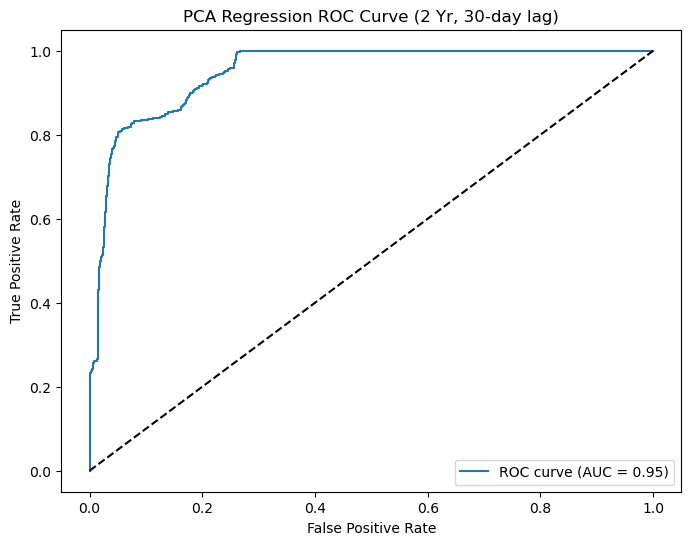

In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, use the predictions from the PCA model: y_pred_pca_2yr and targets: y_test_2yr.
threshold_2yr = np.median(y_test_2yr)
y_test_bin_2yr = (y_test_2yr > threshold_2yr).astype(int)
y_pred_pca_bin_2yr = (y_pred_pca_2yr > threshold_2yr).astype(int)

cm_pca_2yr = confusion_matrix(y_test_bin_2yr, y_pred_pca_bin_2yr)
accuracy_pca_2yr = accuracy_score(y_test_bin_2yr, y_pred_pca_bin_2yr)
fpr_pca_2yr, tpr_pca_2yr, _ = roc_curve(y_test_bin_2yr, y_pred_pca_2yr)
roc_auc_pca_2yr = auc(fpr_pca_2yr, tpr_pca_2yr)

print("2 Yr - PCA Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_2yr)
print("Accuracy:", accuracy_pca_2yr)
print("ROC AUC:", roc_auc_pca_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_2yr, tpr_pca_2yr, label=f'ROC curve (AUC = {roc_auc_pca_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (2 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


2 Yr - Random Forest Regression Classification Metrics:
Confusion Matrix:
[[683  60]
 [181 561]]
Accuracy: 0.8377104377104377
ROC AUC: 0.9471817828937106


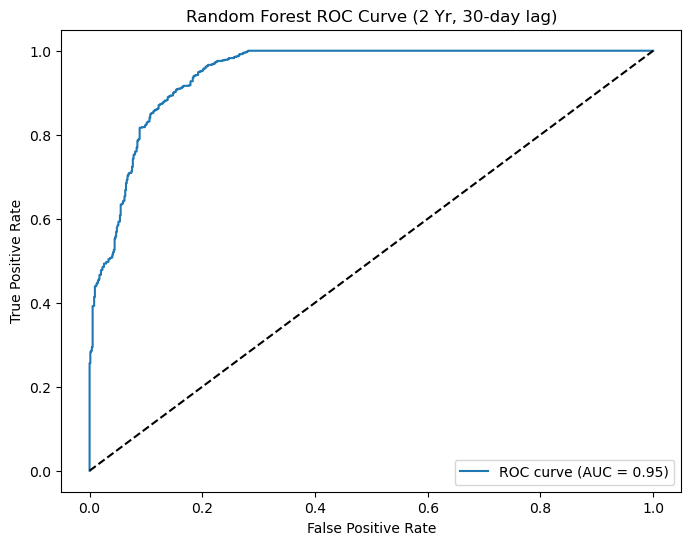

In [73]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, using Random Forest predictions: y_pred_rf_2yr and targets: y_test_2yr.
threshold_rf_2yr = np.median(y_test_2yr)
y_test_bin_rf_2yr = (y_test_2yr > threshold_rf_2yr).astype(int)
y_pred_rf_bin_2yr = (y_pred_rf_2yr > threshold_rf_2yr).astype(int)

cm_rf_2yr = confusion_matrix(y_test_bin_rf_2yr, y_pred_rf_bin_2yr)
accuracy_rf_2yr = accuracy_score(y_test_bin_rf_2yr, y_pred_rf_bin_2yr)
fpr_rf_2yr, tpr_rf_2yr, _ = roc_curve(y_test_bin_rf_2yr, y_pred_rf_2yr)
roc_auc_rf_2yr = auc(fpr_rf_2yr, tpr_rf_2yr)

print("2 Yr - Random Forest Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_2yr)
print("Accuracy:", accuracy_rf_2yr)
print("ROC AUC:", roc_auc_rf_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_2yr, tpr_rf_2yr, label=f'ROC curve (AUC = {roc_auc_rf_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (2 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


2 Yr - Neural Network Regression Classification Metrics:
Confusion Matrix:
[[619 124]
 [ 73 669]]
Accuracy: 0.8673400673400673
ROC AUC: 0.9489158470976191


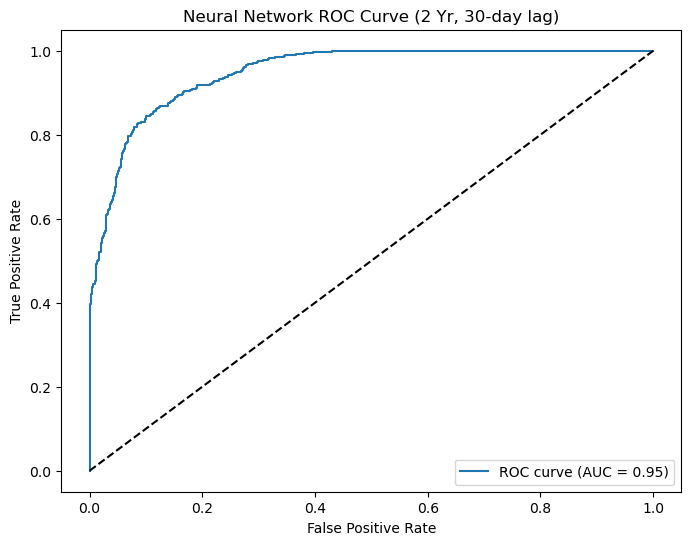

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, using Neural Network predictions: y_pred_nn_2yr and targets: y_test_2yr.
threshold_nn_2yr = np.median(y_test_2yr)
y_test_bin_nn_2yr = (y_test_2yr > threshold_nn_2yr).astype(int)
y_pred_nn_bin_2yr = (y_pred_nn_2yr > threshold_nn_2yr).astype(int)

cm_nn_2yr = confusion_matrix(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
accuracy_nn_2yr = accuracy_score(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
fpr_nn_2yr, tpr_nn_2yr, _ = roc_curve(y_test_bin_nn_2yr, y_pred_nn_2yr)
roc_auc_nn_2yr = auc(fpr_nn_2yr, tpr_nn_2yr)

print("2 Yr - Neural Network Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_2yr)
print("Accuracy:", accuracy_nn_2yr)
print("ROC AUC:", roc_auc_nn_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_2yr, tpr_nn_2yr, label=f'ROC curve (AUC = {roc_auc_nn_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (2 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


2 Yr - Transformer Regression Classification Metrics:
Confusion Matrix:
[[647  96]
 [119 623]]
Accuracy: 0.8552188552188552
ROC AUC: 0.9571671630637069


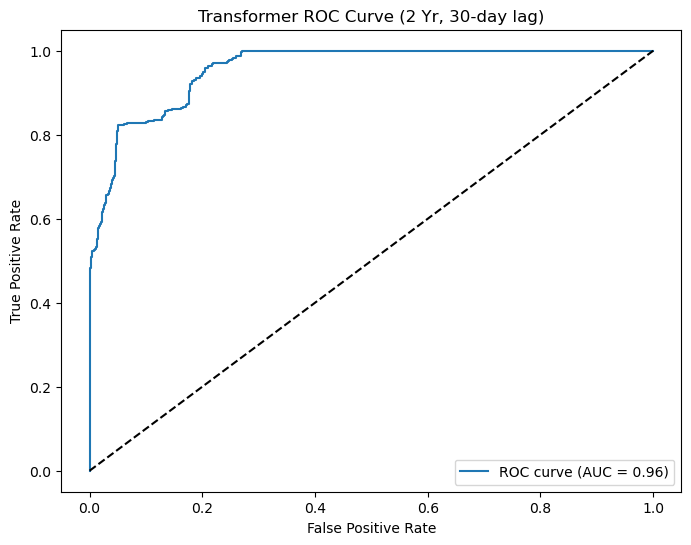

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, using Transformer predictions: y_pred_trans_2yr and targets: y_test_seq_2yr.
# We assume y_test_seq_2yr is 1D (or take column index 0 if multi-output).
threshold_trans_2yr = np.median(y_test_seq_2yr)
y_test_bin_trans_2yr = (y_test_seq_2yr > threshold_trans_2yr).astype(int)
y_pred_trans_bin_2yr = (y_pred_trans_2yr > threshold_trans_2yr).astype(int)

cm_trans_2yr = confusion_matrix(y_test_bin_trans_2yr, y_pred_trans_bin_2yr)
accuracy_trans_2yr = accuracy_score(y_test_bin_trans_2yr, y_pred_trans_bin_2yr)
fpr_trans_2yr, tpr_trans_2yr, _ = roc_curve(y_test_bin_trans_2yr, y_pred_trans_2yr)
roc_auc_trans_2yr = auc(fpr_trans_2yr, tpr_trans_2yr)

print("2 Yr - Transformer Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_2yr)
print("Accuracy:", accuracy_trans_2yr)
print("ROC AUC:", roc_auc_trans_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_2yr, tpr_trans_2yr, label=f'ROC curve (AUC = {roc_auc_trans_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (2 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


In [24]:
# Cell for 10 Yr Forecasting using 30-day lagged values of GARCH_10Yr, PE_10Yr, and HE_10Yr

window = 30
df_pred_10yr = df_combined[['GARCH_10Yr', 'PE_10Yr', 'HE_10Yr']]
target_10yr = df_combined['10 Yr']

X_flat_10yr, y_flat_10yr = create_sequences_flat(df_pred_10yr, target_10yr, window)
X_seq_10yr, y_seq_10yr = create_sequences_transformer(df_pred_10yr, target_10yr, window)

split_idx = int(0.8 * len(X_flat_10yr))
X_train_flat_10yr, X_test_flat_10yr = X_flat_10yr[:split_idx], X_flat_10yr[split_idx:]
y_train_10yr, y_test_10yr = y_flat_10yr[:split_idx], y_flat_10yr[split_idx:]

X_train_seq_10yr, X_test_seq_10yr = X_seq_10yr[:split_idx], X_seq_10yr[split_idx:]
y_train_seq_10yr, y_test_seq_10yr = y_seq_10yr[:split_idx], y_seq_10yr[split_idx:]

scaler_10yr = StandardScaler()
X_train_flat_10yr_scaled = scaler_10yr.fit_transform(X_train_flat_10yr)
X_test_flat_10yr_scaled = scaler_10yr.transform(X_test_flat_10yr)

#### PCA Regression for 10 Yr ####
pca_10yr = PCA(n_components=10)
X_train_pca_10yr = pca_10yr.fit_transform(X_train_flat_10yr_scaled)
X_test_pca_10yr = pca_10yr.transform(X_test_flat_10yr_scaled)
lr_10yr = LinearRegression()
lr_10yr.fit(X_train_pca_10yr, y_train_10yr)
y_pred_pca_10yr = lr_10yr.predict(X_test_pca_10yr)
rmse_pca_10yr = np.sqrt(mean_squared_error(y_test_10yr, y_pred_pca_10yr))
print("10 Yr - PCA Regression RMSE:", rmse_pca_10yr)

#### Random Forest for 10 Yr ####
rf_10yr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_10yr.fit(X_train_flat_10yr_scaled, y_train_10yr)
y_pred_rf_10yr = rf_10yr.predict(X_test_flat_10yr_scaled)
rmse_rf_10yr = np.sqrt(mean_squared_error(y_test_10yr, y_pred_rf_10yr))
print("10 Yr - Random Forest RMSE:", rmse_rf_10yr)

#### Neural Network for 10 Yr ####
model_nn_10yr = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flat_10yr_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_nn_10yr.compile(optimizer='adam', loss='mse')
history_nn_10yr = model_nn_10yr.fit(X_train_flat_10yr_scaled, y_train_10yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_nn_10yr = model_nn_10yr.predict(X_test_flat_10yr_scaled).flatten()
rmse_nn_10yr = np.sqrt(mean_squared_error(y_test_10yr, y_pred_nn_10yr))
print("10 Yr - Neural Network RMSE:", rmse_nn_10yr)

#### Transformer for 10 Yr ####
input_shape_10yr = X_train_seq_10yr.shape[1:]  # (window, num_features)
inputs_10yr = Input(shape=input_shape_10yr)
x_10yr = Dense(64, activation='relu')(inputs_10yr)
x_10yr = transformer_encoder(x_10yr, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x_10yr = GlobalAveragePooling1D()(x_10yr)
x_10yr = Dense(32, activation='relu')(x_10yr)
outputs_10yr = Dense(1)(x_10yr)
model_trans_10yr = Model(inputs_10yr, outputs_10yr)
model_trans_10yr.compile(optimizer="adam", loss="mse")
model_trans_10yr.summary()
history_trans_10yr = model_trans_10yr.fit(X_train_seq_10yr, y_train_seq_10yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_trans_10yr = model_trans_10yr.predict(X_test_seq_10yr).flatten()
rmse_trans_10yr = np.sqrt(mean_squared_error(y_test_seq_10yr, y_pred_trans_10yr))
print("10 Yr - Transformer RMSE:", rmse_trans_10yr)


NameError: name 'create_sequences_flat' is not defined

10 Yr - PCA Regression Classification Metrics:
Confusion Matrix:
[[616 128]
 [ 53 688]]
Accuracy: 0.8781144781144781
ROC AUC: 0.9305791360120732


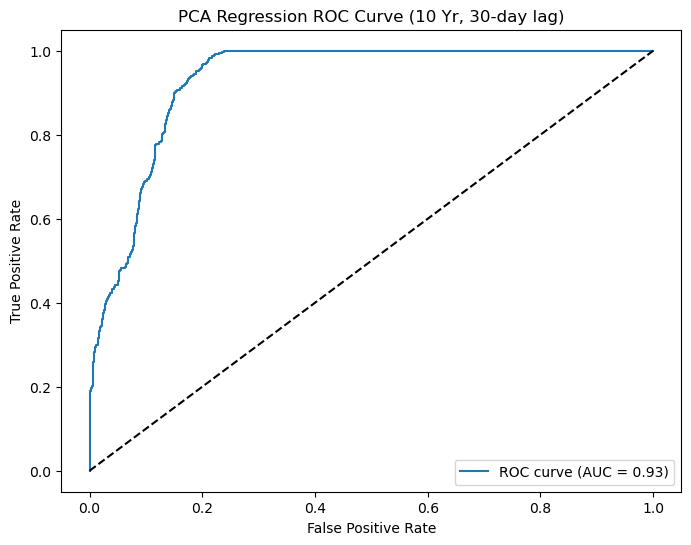

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using PCA predictions: y_pred_pca_10yr and targets: y_test_10yr.
threshold_10yr = np.median(y_test_10yr)
y_test_bin_10yr = (y_test_10yr > threshold_10yr).astype(int)
y_pred_pca_bin_10yr = (y_pred_pca_10yr > threshold_10yr).astype(int)

cm_pca_10yr = confusion_matrix(y_test_bin_10yr, y_pred_pca_bin_10yr)
accuracy_pca_10yr = accuracy_score(y_test_bin_10yr, y_pred_pca_bin_10yr)
fpr_pca_10yr, tpr_pca_10yr, _ = roc_curve(y_test_bin_10yr, y_pred_pca_10yr)
roc_auc_pca_10yr = auc(fpr_pca_10yr, tpr_pca_10yr)

print("10 Yr - PCA Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_10yr)
print("Accuracy:", accuracy_pca_10yr)
print("ROC AUC:", roc_auc_pca_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_10yr, tpr_pca_10yr, label=f'ROC curve (AUC = {roc_auc_pca_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


10 Yr - Random Forest Regression Classification Metrics:
Confusion Matrix:
[[339 405]
 [175 566]]
Accuracy: 0.6094276094276094
ROC AUC: 0.7371495581385225


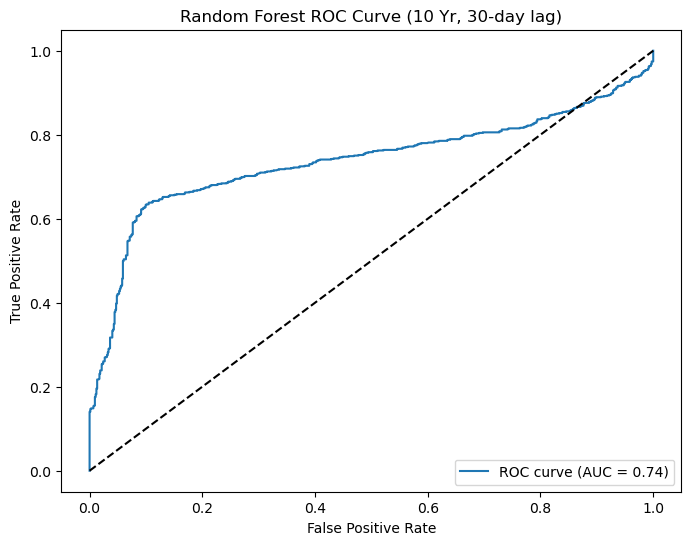

In [78]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using Random Forest predictions: y_pred_rf_10yr and targets: y_test_10yr.
threshold_rf_10yr = np.median(y_test_10yr)
y_test_bin_rf_10yr = (y_test_10yr > threshold_rf_10yr).astype(int)
y_pred_rf_bin_10yr = (y_pred_rf_10yr > threshold_rf_10yr).astype(int)

cm_rf_10yr = confusion_matrix(y_test_bin_rf_10yr, y_pred_rf_bin_10yr)
accuracy_rf_10yr = accuracy_score(y_test_bin_rf_10yr, y_pred_rf_bin_10yr)
fpr_rf_10yr, tpr_rf_10yr, _ = roc_curve(y_test_bin_rf_10yr, y_pred_rf_10yr)
roc_auc_rf_10yr = auc(fpr_rf_10yr, tpr_rf_10yr)

print("10 Yr - Random Forest Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_10yr)
print("Accuracy:", accuracy_rf_10yr)
print("ROC AUC:", roc_auc_rf_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_10yr, tpr_rf_10yr, label=f'ROC curve (AUC = {roc_auc_rf_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


10 Yr - Neural Network Regression Classification Metrics:
Confusion Matrix:
[[444 300]
 [234 507]]
Accuracy: 0.6404040404040404
ROC AUC: 0.6842613149913659


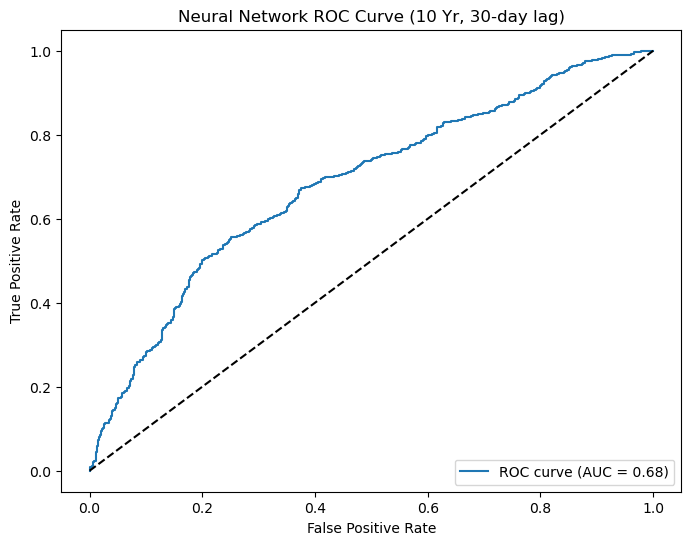

In [79]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using Neural Network predictions: y_pred_nn_10yr and targets: y_test_10yr.
threshold_nn_10yr = np.median(y_test_10yr)
y_test_bin_nn_10yr = (y_test_10yr > threshold_nn_10yr).astype(int)
y_pred_nn_bin_10yr = (y_pred_nn_10yr > threshold_nn_10yr).astype(int)

cm_nn_10yr = confusion_matrix(y_test_bin_nn_10yr, y_pred_nn_bin_10yr)
accuracy_nn_10yr = accuracy_score(y_test_bin_nn_10yr, y_pred_nn_bin_10yr)
fpr_nn_10yr, tpr_nn_10yr, _ = roc_curve(y_test_bin_nn_10yr, y_pred_nn_10yr)
roc_auc_nn_10yr = auc(fpr_nn_10yr, tpr_nn_10yr)

print("10 Yr - Neural Network Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_10yr)
print("Accuracy:", accuracy_nn_10yr)
print("ROC AUC:", roc_auc_nn_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_10yr, tpr_nn_10yr, label=f'ROC curve (AUC = {roc_auc_nn_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


10 Yr - Transformer Regression Classification Metrics:
Confusion Matrix:
[[378 366]
 [ 99 642]]
Accuracy: 0.6868686868686869
ROC AUC: 0.7903479749829495


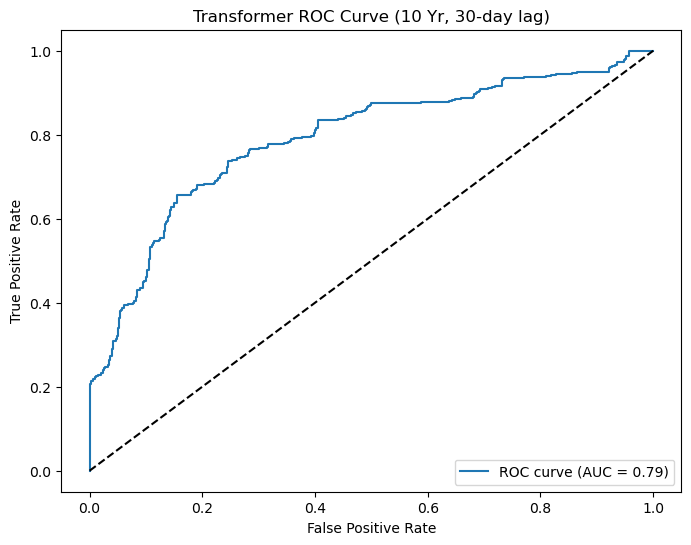

In [80]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using Transformer predictions: y_pred_trans_10yr and targets: y_test_seq_10yr.
threshold_trans_10yr = np.median(y_test_seq_10yr)
y_test_bin_trans_10yr = (y_test_seq_10yr > threshold_trans_10yr).astype(int)
y_pred_trans_bin_10yr = (y_pred_trans_10yr > threshold_trans_10yr).astype(int)

cm_trans_10yr = confusion_matrix(y_test_bin_trans_10yr, y_pred_trans_bin_10yr)
accuracy_trans_10yr = accuracy_score(y_test_bin_trans_10yr, y_pred_trans_bin_10yr)
fpr_trans_10yr, tpr_trans_10yr, _ = roc_curve(y_test_bin_trans_10yr, y_pred_trans_10yr)
roc_auc_trans_10yr = auc(fpr_trans_10yr, tpr_trans_10yr)

print("10 Yr - Transformer Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_10yr)
print("Accuracy:", accuracy_trans_10yr)
print("ROC AUC:", roc_auc_trans_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_10yr, tpr_trans_10yr, label=f'ROC curve (AUC = {roc_auc_trans_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


3 Mo - PCA Regression RMSE: 1.5686762203855866
3 Mo - Random Forest RMSE: 1.4960146017443487


c:\Users\npwol\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3 Mo - Neural Network RMSE: 2.6682497840388906


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 180, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 180, 64)   │        256 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 64)   │     66,368 │ dense_46[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 180, 64)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 180, 64)   │          0 │ dense_46[0][0],   │
│                     │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 180, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 180, 64)   │      4,160 │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 180, 64)   │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 180, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 1)         │         33 │ dense_49[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,313 (302.00 KB)

 Trainable params: 77,313 (302.00 KB)

 Non-trainable params: 0 (0.00 B)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
3 Mo - Transformer RMSE: 1.3816237176291486
3 Mo - PCA Regression Classification Metrics:
Confusion Matrix:
[[419 327]
 [105 634]]
Accuracy: 0.7090909090909091
ROC AUC: 0.8257100567029572


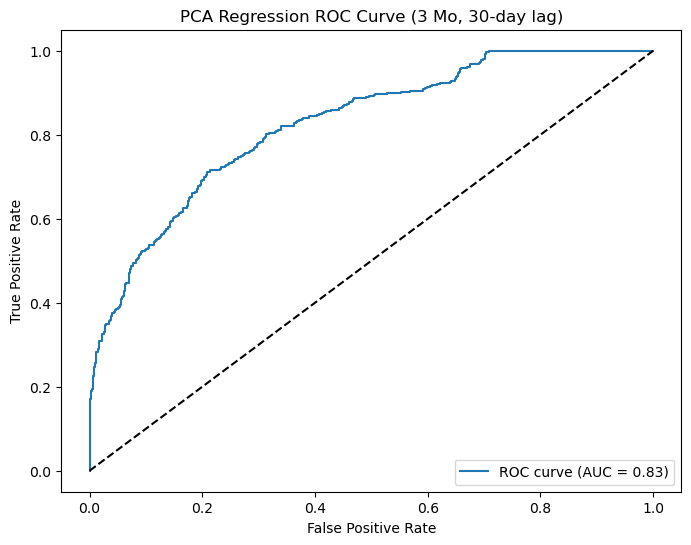

3 Mo - Random Forest Regression Classification Metrics:
Confusion Matrix:
[[656  90]
 [ 63 676]]
Accuracy: 0.896969696969697
ROC AUC: 0.9776090434505001


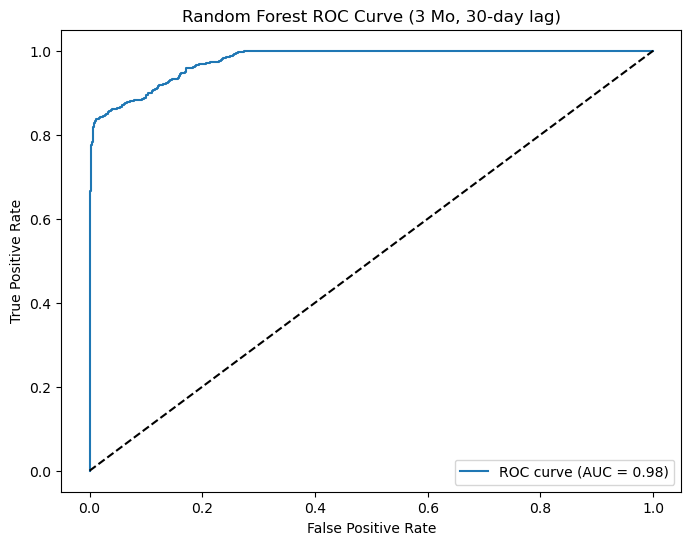

3 Mo - Neural Network Regression Classification Metrics:
Confusion Matrix:
[[643 103]
 [138 601]]
Accuracy: 0.8377104377104377
ROC AUC: 0.9126346377794787


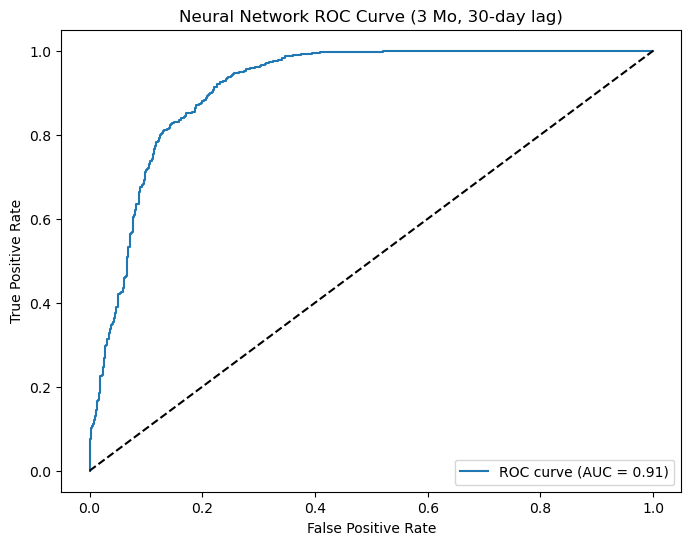

3 Mo - Transformer Regression Classification Metrics:
Confusion Matrix:
[[661  85]
 [ 77 662]]
Accuracy: 0.8909090909090909
ROC AUC: 0.9694954053554001


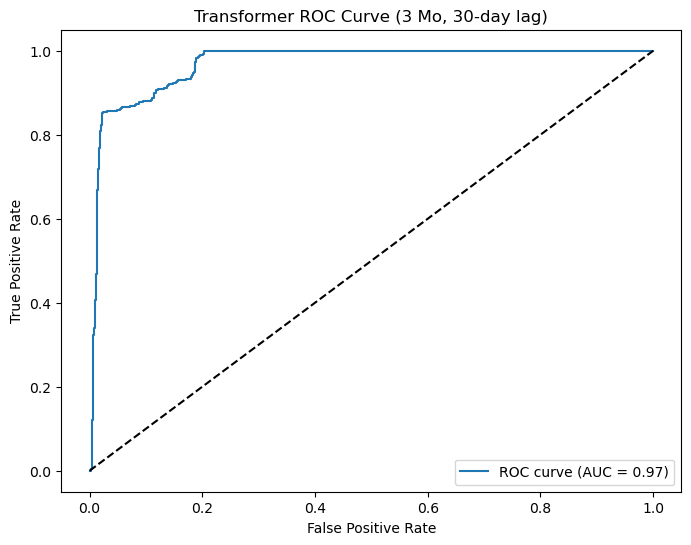

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras import Model

# Helper functions to create sequences
def create_sequences_flat(X_df, y_series, window):
    """Creates 2D sequences (flattened) for PCA, RF, and NN.
    Returns X of shape (n_samples, window * num_features) and y of shape (n_samples,)."""
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values.flatten())
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

def create_sequences_transformer(X_df, y_series, window):
    """Creates 3D sequences for the transformer.
    Returns X of shape (n_samples, window, num_features) and y of shape (n_samples,)."""
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values)
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

# Parameters
window = 180

# For 3‑Mo yield, predictors come from the corresponding columns in df_combined.
df_pred_3mo = df_combined[['GARCH_3Mo', 'PE_3Mo', 'HE_3Mo']]
target_3mo = df_combined['3 Mo']

# Create sequences for flat models (PCA, Random Forest, Neural Network)
X_flat_3mo, y_flat_3mo = create_sequences_flat(df_pred_3mo, target_3mo, window)
# Create sequences for the Transformer (keeping time structure)
X_seq_3mo, y_seq_3mo = create_sequences_transformer(df_pred_3mo, target_3mo, window)

# Split into training and test sets (preserving time order)
split_idx = int(0.8 * len(X_flat_3mo))
X_train_flat, X_test_flat = X_flat_3mo[:split_idx], X_flat_3mo[split_idx:]
y_train, y_test = y_flat_3mo[:split_idx], y_flat_3mo[split_idx:]

X_train_seq, X_test_seq = X_seq_3mo[:split_idx], X_seq_3mo[split_idx:]
y_train_seq, y_test_seq = y_seq_3mo[:split_idx], y_seq_3mo[split_idx:]

# Standardize the flat predictors
scaler_3mo = StandardScaler()
X_train_flat_scaled = scaler_3mo.fit_transform(X_train_flat)
X_test_flat_scaled = scaler_3mo.transform(X_test_flat)

#### PCA Regression Model for 3 Mo ####
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_flat_scaled)
X_test_pca = pca.transform(X_test_flat_scaled)

lr = LinearRegression()
lr.fit(X_train_pca, y_train)
y_pred_pca = lr.predict(X_test_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
print("3 Mo - PCA Regression RMSE:", rmse_pca)

#### Random Forest Model for 3 Mo ####
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_flat_scaled, y_train)
y_pred_rf = rf.predict(X_test_flat_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("3 Mo - Random Forest RMSE:", rmse_rf)

#### Neural Network Model for 3 Mo ####
model_nn_3mo = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flat_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_nn_3mo.compile(optimizer='adam', loss='mse')
history_nn_3mo = model_nn_3mo.fit(X_train_flat_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_nn = model_nn_3mo.predict(X_test_flat_scaled).flatten()
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("3 Mo - Neural Network RMSE:", rmse_nn)

#### Transformer Model for 3 Mo ####
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

input_shape = X_train_seq.shape[1:]  # (window, num_features) = (30, 3)
inputs = Input(shape=input_shape)
x = Dense(64, activation='relu')(inputs)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)
model_trans_3mo = Model(inputs, outputs)
model_trans_3mo.compile(optimizer="adam", loss="mse")
model_trans_3mo.summary()

history_trans_3mo = model_trans_3mo.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_trans = model_trans_3mo.predict(X_test_seq).flatten()
rmse_trans = np.sqrt(mean_squared_error(y_test_seq, y_pred_trans))
print("3 Mo - Transformer RMSE:", rmse_trans)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

# If your forecasting cell used different variable names, set aliases here.
# For example, if your forecasting cell defined:
#   y_test (for flat predictions) and y_test_seq (for transformer),
#   y_pred_pca, y_pred_rf, y_pred_nn, and y_pred_trans,
# then we set:
try:
    y_test_3mo
except NameError:
    print("Defining y_test_3mo and related variables from forecasting results...")
    y_test_3mo = y_test        # y_test from the forecasting cell for 3 Mo (flat model)
    y_pred_pca_3mo = y_pred_pca  # PCA regression predictions for 3 Mo
    y_pred_rf_3mo = y_pred_rf    # Random Forest predictions for 3 Mo
    y_pred_nn_3mo = y_pred_nn    # Neural Network predictions for 3 Mo
    y_test_seq_3mo = y_test_seq  # Transformer test targets (3 Mo, sequence version)
    y_pred_trans_3mo = y_pred_trans  # Transformer predictions for 3 Mo

# --- PCA Regression (3 Mo) Classification Metrics ---
threshold_3mo = np.median(y_test_3mo)
y_test_bin_3mo = (y_test_3mo > threshold_3mo).astype(int)
y_pred_pca_bin_3mo = (y_pred_pca_3mo > threshold_3mo).astype(int)

cm_pca_3mo = confusion_matrix(y_test_bin_3mo, y_pred_pca_bin_3mo)
accuracy_pca_3mo = accuracy_score(y_test_bin_3mo, y_pred_pca_bin_3mo)
fpr_pca_3mo, tpr_pca_3mo, _ = roc_curve(y_test_bin_3mo, y_pred_pca_3mo)
roc_auc_pca_3mo = auc(fpr_pca_3mo, tpr_pca_3mo)

print("3 Mo - PCA Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_3mo)
print("Accuracy:", accuracy_pca_3mo)
print("ROC AUC:", roc_auc_pca_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_3mo, tpr_pca_3mo, label=f'ROC curve (AUC = {roc_auc_pca_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

# --- Random Forest Regression (3 Mo) Classification Metrics ---
threshold_rf_3mo = np.median(y_test_3mo)
y_test_bin_rf_3mo = (y_test_3mo > threshold_rf_3mo).astype(int)
y_pred_rf_bin_3mo = (y_pred_rf_3mo > threshold_rf_3mo).astype(int)

cm_rf_3mo = confusion_matrix(y_test_bin_rf_3mo, y_pred_rf_bin_3mo)
accuracy_rf_3mo = accuracy_score(y_test_bin_rf_3mo, y_pred_rf_bin_3mo)
fpr_rf_3mo, tpr_rf_3mo, _ = roc_curve(y_test_bin_rf_3mo, y_pred_rf_3mo)
roc_auc_rf_3mo = auc(fpr_rf_3mo, tpr_rf_3mo)

print("3 Mo - Random Forest Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_3mo)
print("Accuracy:", accuracy_rf_3mo)
print("ROC AUC:", roc_auc_rf_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_3mo, tpr_rf_3mo, label=f'ROC curve (AUC = {roc_auc_rf_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

# --- Neural Network Regression (3 Mo) Classification Metrics ---
threshold_nn_3mo = np.median(y_test_3mo)
y_test_bin_nn_3mo = (y_test_3mo > threshold_nn_3mo).astype(int)
y_pred_nn_bin_3mo = (y_pred_nn_3mo > threshold_nn_3mo).astype(int)

cm_nn_3mo = confusion_matrix(y_test_bin_nn_3mo, y_pred_nn_bin_3mo)
accuracy_nn_3mo = accuracy_score(y_test_bin_nn_3mo, y_pred_nn_bin_3mo)
fpr_nn_3mo, tpr_nn_3mo, _ = roc_curve(y_test_bin_nn_3mo, y_pred_nn_3mo)
roc_auc_nn_3mo = auc(fpr_nn_3mo, tpr_nn_3mo)

print("3 Mo - Neural Network Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_3mo)
print("Accuracy:", accuracy_nn_3mo)
print("ROC AUC:", roc_auc_nn_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_3mo, tpr_nn_3mo, label=f'ROC curve (AUC = {roc_auc_nn_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

# --- Transformer Regression (3 Mo) Classification Metrics ---
threshold_trans_3mo = np.median(y_test_seq_3mo)
y_test_bin_trans_3mo = (y_test_seq_3mo > threshold_trans_3mo).astype(int)
y_pred_trans_bin_3mo = (y_pred_trans_3mo > threshold_trans_3mo).astype(int)

cm_trans_3mo = confusion_matrix(y_test_bin_trans_3mo, y_pred_trans_bin_3mo)
accuracy_trans_3mo = accuracy_score(y_test_bin_trans_3mo, y_pred_trans_bin_3mo)
fpr_trans_3mo, tpr_trans_3mo, _ = roc_curve(y_test_bin_trans_3mo, y_pred_trans_3mo)
roc_auc_trans_3mo = auc(fpr_trans_3mo, tpr_trans_3mo)

print("3 Mo - Transformer Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_3mo)
print("Accuracy:", accuracy_trans_3mo)
print("ROC AUC:", roc_auc_trans_3mo)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_3mo, tpr_trans_3mo, label=f'ROC curve (AUC = {roc_auc_trans_3mo:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (3 Mo, 30-day lag)')
plt.legend(loc='lower right')
plt.show()



In [85]:
# Cell for 2 Yr Forecasting using 30-day lagged values of GARCH_2Yr, PE_2Yr, and HE_2Yr

def create_sequences_flat(X_df, y_series, window):
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values.flatten())
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

def create_sequences_transformer(X_df, y_series, window):
    X, y = [], []
    for i in range(window, len(X_df)):
        X.append(X_df.iloc[i-window:i].values)
        y.append(y_series.iloc[i])
    return np.array(X), np.array(y)

window = 180

df_pred_2yr = df_combined[['GARCH_2Yr', 'PE_2Yr', 'HE_2Yr']]
target_2yr = df_combined['2 Yr']

X_flat_2yr, y_flat_2yr = create_sequences_flat(df_pred_2yr, target_2yr, window)
X_seq_2yr, y_seq_2yr = create_sequences_transformer(df_pred_2yr, target_2yr, window)

split_idx = int(0.8 * len(X_flat_2yr))
X_train_flat_2yr, X_test_flat_2yr = X_flat_2yr[:split_idx], X_flat_2yr[split_idx:]
y_train_2yr, y_test_2yr = y_flat_2yr[:split_idx], y_flat_2yr[split_idx:]

X_train_seq_2yr, X_test_seq_2yr = X_seq_2yr[:split_idx], X_seq_2yr[split_idx:]
y_train_seq_2yr, y_test_seq_2yr = y_seq_2yr[:split_idx], y_seq_2yr[split_idx:]

scaler_2yr = StandardScaler()
X_train_flat_2yr_scaled = scaler_2yr.fit_transform(X_train_flat_2yr)
X_test_flat_2yr_scaled = scaler_2yr.transform(X_test_flat_2yr)

#### PCA Regression for 2 Yr ####
pca_2yr = PCA(n_components=10)
X_train_pca_2yr = pca_2yr.fit_transform(X_train_flat_2yr_scaled)
X_test_pca_2yr = pca_2yr.transform(X_test_flat_2yr_scaled)
lr_2yr = LinearRegression()
lr_2yr.fit(X_train_pca_2yr, y_train_2yr)
y_pred_pca_2yr = lr_2yr.predict(X_test_pca_2yr)
rmse_pca_2yr = np.sqrt(mean_squared_error(y_test_2yr, y_pred_pca_2yr))
print("2 Yr - PCA Regression RMSE:", rmse_pca_2yr)

#### Random Forest for 2 Yr ####
rf_2yr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_2yr.fit(X_train_flat_2yr_scaled, y_train_2yr)
y_pred_rf_2yr = rf_2yr.predict(X_test_flat_2yr_scaled)
rmse_rf_2yr = np.sqrt(mean_squared_error(y_test_2yr, y_pred_rf_2yr))
print("2 Yr - Random Forest RMSE:", rmse_rf_2yr)

#### Neural Network for 2 Yr ####
model_nn_2yr = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flat_2yr_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_nn_2yr.compile(optimizer='adam', loss='mse')
history_nn_2yr = model_nn_2yr.fit(X_train_flat_2yr_scaled, y_train_2yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_nn_2yr = model_nn_2yr.predict(X_test_flat_2yr_scaled).flatten()
rmse_nn_2yr = np.sqrt(mean_squared_error(y_test_2yr, y_pred_nn_2yr))
print("2 Yr - Neural Network RMSE:", rmse_nn_2yr)

#### Transformer for 2 Yr ####
input_shape_2yr = X_train_seq_2yr.shape[1:]  # (window, num_features) = (30, 3)
inputs_2yr = Input(shape=input_shape_2yr)
x_2yr = Dense(64, activation='relu')(inputs_2yr)
x_2yr = transformer_encoder(x_2yr, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x_2yr = GlobalAveragePooling1D()(x_2yr)
x_2yr = Dense(32, activation='relu')(x_2yr)
outputs_2yr = Dense(1)(x_2yr)
model_trans_2yr = Model(inputs_2yr, outputs_2yr)
model_trans_2yr.compile(optimizer="adam", loss="mse")
model_trans_2yr.summary()
history_trans_2yr = model_trans_2yr.fit(X_train_seq_2yr, y_train_seq_2yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_trans_2yr = model_trans_2yr.predict(X_test_seq_2yr).flatten()
rmse_trans_2yr = np.sqrt(mean_squared_error(y_test_seq_2yr, y_pred_trans_2yr))
print("2 Yr - Transformer RMSE:", rmse_trans_2yr)


2 Yr - PCA Regression RMSE: 2.0113735594967834
2 Yr - Random Forest RMSE: 1.3828029241425481


c:\Users\npwol\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2 Yr - Neural Network RMSE: 1.283520498547994


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 180, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 180, 64)   │        256 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 64)   │     66,368 │ dense_54[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_54[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 180, 64)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 180, 64)   │          0 │ dense_54[0][0],   │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 180, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 180, 64)   │      4,160 │ dense_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 180, 64)   │          0 │ dense_56[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 180, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 1)         │         33 │ dense_57[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,313 (302.00 KB)

 Trainable params: 77,313 (302.00 KB)

 Non-trainable params: 0 (0.00 B)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
2 Yr - Transformer RMSE: 1.3387276040327407


2 Yr - PCA Regression Classification Metrics:
Confusion Matrix:
[[533 195]
 [103 624]]
Accuracy: 0.7951890034364261
ROC AUC: 0.857654896685158


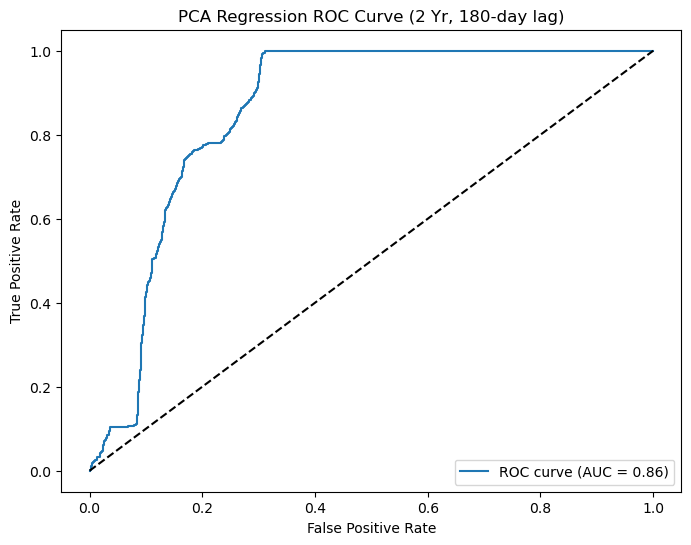

2 Yr - Random Forest Regression Classification Metrics:
Confusion Matrix:
[[557 171]
 [188 539]]
Accuracy: 0.7532646048109966
ROC AUC: 0.8420509167586195


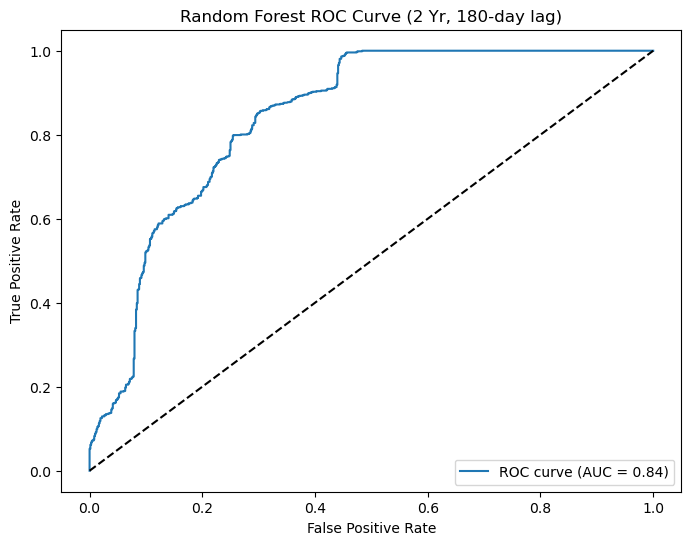

2 Yr - Neural Network Regression Classification Metrics:
Confusion Matrix:
[[541 187]
 [145 582]]
Accuracy: 0.7718213058419244
ROC AUC: 0.8553459951327902


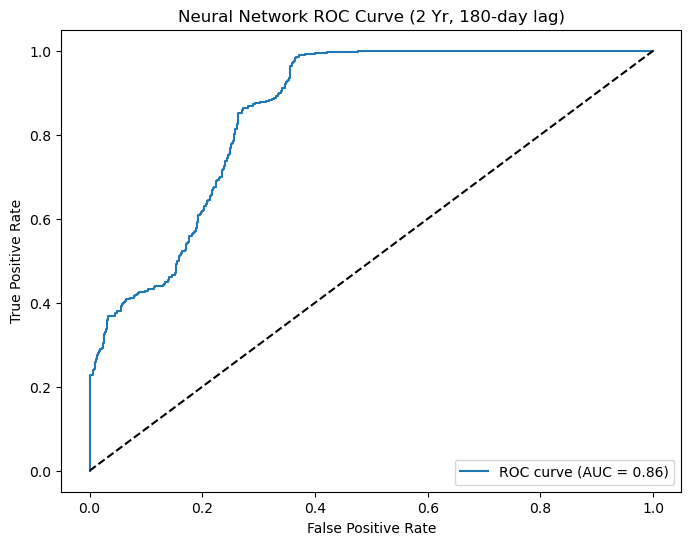

2 Yr - Transformer Regression Classification Metrics:
Confusion Matrix:
[[556 172]
 [135 592]]
Accuracy: 0.7890034364261168
ROC AUC: 0.8441831552216698


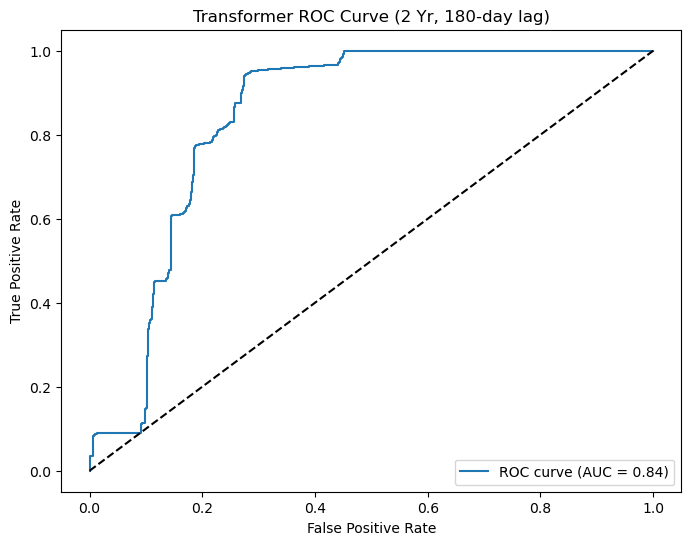

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, use the predictions from the PCA model: y_pred_pca_2yr and targets: y_test_2yr.
threshold_2yr = np.median(y_test_2yr)
y_test_bin_2yr = (y_test_2yr > threshold_2yr).astype(int)
y_pred_pca_bin_2yr = (y_pred_pca_2yr > threshold_2yr).astype(int)

cm_pca_2yr = confusion_matrix(y_test_bin_2yr, y_pred_pca_bin_2yr)
accuracy_pca_2yr = accuracy_score(y_test_bin_2yr, y_pred_pca_bin_2yr)
fpr_pca_2yr, tpr_pca_2yr, _ = roc_curve(y_test_bin_2yr, y_pred_pca_2yr)
roc_auc_pca_2yr = auc(fpr_pca_2yr, tpr_pca_2yr)

print("2 Yr - PCA Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_2yr)
print("Accuracy:", accuracy_pca_2yr)
print("ROC AUC:", roc_auc_pca_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_2yr, tpr_pca_2yr, label=f'ROC curve (AUC = {roc_auc_pca_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (2 Yr, 180-day lag)')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, using Random Forest predictions: y_pred_rf_2yr and targets: y_test_2yr.
threshold_rf_2yr = np.median(y_test_2yr)
y_test_bin_rf_2yr = (y_test_2yr > threshold_rf_2yr).astype(int)
y_pred_rf_bin_2yr = (y_pred_rf_2yr > threshold_rf_2yr).astype(int)

cm_rf_2yr = confusion_matrix(y_test_bin_rf_2yr, y_pred_rf_bin_2yr)
accuracy_rf_2yr = accuracy_score(y_test_bin_rf_2yr, y_pred_rf_bin_2yr)
fpr_rf_2yr, tpr_rf_2yr, _ = roc_curve(y_test_bin_rf_2yr, y_pred_rf_2yr)
roc_auc_rf_2yr = auc(fpr_rf_2yr, tpr_rf_2yr)

print("2 Yr - Random Forest Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_2yr)
print("Accuracy:", accuracy_rf_2yr)
print("ROC AUC:", roc_auc_rf_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_2yr, tpr_rf_2yr, label=f'ROC curve (AUC = {roc_auc_rf_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (2 Yr, 180-day lag)')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, using Neural Network predictions: y_pred_nn_2yr and targets: y_test_2yr.
threshold_nn_2yr = np.median(y_test_2yr)
y_test_bin_nn_2yr = (y_test_2yr > threshold_nn_2yr).astype(int)
y_pred_nn_bin_2yr = (y_pred_nn_2yr > threshold_nn_2yr).astype(int)

cm_nn_2yr = confusion_matrix(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
accuracy_nn_2yr = accuracy_score(y_test_bin_nn_2yr, y_pred_nn_bin_2yr)
fpr_nn_2yr, tpr_nn_2yr, _ = roc_curve(y_test_bin_nn_2yr, y_pred_nn_2yr)
roc_auc_nn_2yr = auc(fpr_nn_2yr, tpr_nn_2yr)

print("2 Yr - Neural Network Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_2yr)
print("Accuracy:", accuracy_nn_2yr)
print("ROC AUC:", roc_auc_nn_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_2yr, tpr_nn_2yr, label=f'ROC curve (AUC = {roc_auc_nn_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (2 Yr, 180-day lag)')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 2 Yr, using Transformer predictions: y_pred_trans_2yr and targets: y_test_seq_2yr.
# We assume y_test_seq_2yr is 1D (or take column index 0 if multi-output).
threshold_trans_2yr = np.median(y_test_seq_2yr)
y_test_bin_trans_2yr = (y_test_seq_2yr > threshold_trans_2yr).astype(int)
y_pred_trans_bin_2yr = (y_pred_trans_2yr > threshold_trans_2yr).astype(int)

cm_trans_2yr = confusion_matrix(y_test_bin_trans_2yr, y_pred_trans_bin_2yr)
accuracy_trans_2yr = accuracy_score(y_test_bin_trans_2yr, y_pred_trans_bin_2yr)
fpr_trans_2yr, tpr_trans_2yr, _ = roc_curve(y_test_bin_trans_2yr, y_pred_trans_2yr)
roc_auc_trans_2yr = auc(fpr_trans_2yr, tpr_trans_2yr)

print("2 Yr - Transformer Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_2yr)
print("Accuracy:", accuracy_trans_2yr)
print("ROC AUC:", roc_auc_trans_2yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_2yr, tpr_trans_2yr, label=f'ROC curve (AUC = {roc_auc_trans_2yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (2 Yr, 180-day lag)')
plt.legend(loc='lower right')
plt.show()




In [27]:
# Cell for 10 Yr Forecasting using 30-day lagged values of GARCH_10Yr, PE_10Yr, and HE_10Yr

window = 180
df_pred_10yr = df_combined[['GARCH_10Yr', 'PE_10Yr', 'HE_10Yr']]
target_10yr = df_combined['10 Yr']

X_flat_10yr, y_flat_10yr = create_sequences_flat(df_pred_10yr, target_10yr, window)
X_seq_10yr, y_seq_10yr = create_sequences_transformer(df_pred_10yr, target_10yr, window)

split_idx = int(0.8 * len(X_flat_10yr))
X_train_flat_10yr, X_test_flat_10yr = X_flat_10yr[:split_idx], X_flat_10yr[split_idx:]
y_train_10yr, y_test_10yr = y_flat_10yr[:split_idx], y_flat_10yr[split_idx:]

X_train_seq_10yr, X_test_seq_10yr = X_seq_10yr[:split_idx], X_seq_10yr[split_idx:]
y_train_seq_10yr, y_test_seq_10yr = y_seq_10yr[:split_idx], y_seq_10yr[split_idx:]

scaler_10yr = StandardScaler()
X_train_flat_10yr_scaled = scaler_10yr.fit_transform(X_train_flat_10yr)
X_test_flat_10yr_scaled = scaler_10yr.transform(X_test_flat_10yr)

#### PCA Regression for 10 Yr ####
pca_10yr = PCA(n_components=10)
X_train_pca_10yr = pca_10yr.fit_transform(X_train_flat_10yr_scaled)
X_test_pca_10yr = pca_10yr.transform(X_test_flat_10yr_scaled)
lr_10yr = LinearRegression()
lr_10yr.fit(X_train_pca_10yr, y_train_10yr)
y_pred_pca_10yr = lr_10yr.predict(X_test_pca_10yr)
rmse_pca_10yr = np.sqrt(mean_squared_error(y_test_10yr, y_pred_pca_10yr))
print("10 Yr - PCA Regression RMSE:", rmse_pca_10yr)

#### Random Forest for 10 Yr ####
rf_10yr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_10yr.fit(X_train_flat_10yr_scaled, y_train_10yr)
y_pred_rf_10yr = rf_10yr.predict(X_test_flat_10yr_scaled)
rmse_rf_10yr = np.sqrt(mean_squared_error(y_test_10yr, y_pred_rf_10yr))
print("10 Yr - Random Forest RMSE:", rmse_rf_10yr)

#### Neural Network for 10 Yr ####
model_nn_10yr = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flat_10yr_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_nn_10yr.compile(optimizer='adam', loss='mse')
history_nn_10yr = model_nn_10yr.fit(X_train_flat_10yr_scaled, y_train_10yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_nn_10yr = model_nn_10yr.predict(X_test_flat_10yr_scaled).flatten()
rmse_nn_10yr = np.sqrt(mean_squared_error(y_test_10yr, y_pred_nn_10yr))
print("10 Yr - Neural Network RMSE:", rmse_nn_10yr)

#### Transformer for 10 Yr ####
input_shape_10yr = X_train_seq_10yr.shape[1:]  # (window, num_features)
inputs_10yr = Input(shape=input_shape_10yr)
x_10yr = Dense(64, activation='relu')(inputs_10yr)
x_10yr = transformer_encoder(x_10yr, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x_10yr = GlobalAveragePooling1D()(x_10yr)
x_10yr = Dense(32, activation='relu')(x_10yr)
outputs_10yr = Dense(1)(x_10yr)
model_trans_10yr = Model(inputs_10yr, outputs_10yr)
model_trans_10yr.compile(optimizer="adam", loss="mse")
model_trans_10yr.summary()
history_trans_10yr = model_trans_10yr.fit(X_train_seq_10yr, y_train_seq_10yr, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_trans_10yr = model_trans_10yr.predict(X_test_seq_10yr).flatten()
rmse_trans_10yr = np.sqrt(mean_squared_error(y_test_seq_10yr, y_pred_trans_10yr))
print("10 Yr - Transformer RMSE:", rmse_trans_10yr)


10 Yr - PCA Regression RMSE: 1.9939530295366765
10 Yr - Random Forest RMSE: 1.2970106882533001


c:\Users\npwol\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10 Yr - Neural Network RMSE: 2.8945722626737367


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 180, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 180, 64)   │        256 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 64)   │     66,368 │ dense_19[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 180, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 180, 64)   │          0 │ dense_19[0][0],   │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 180, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 180, 64)   │      4,160 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 180, 64)   │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 180, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         33 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,313 (302.00 KB)

 Trainable params: 77,313 (302.00 KB)

 Non-trainable params: 0 (0.00 B)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
10 Yr - Transformer RMSE: 1.4914323989650409


10 Yr - PCA Regression Classification Metrics:
Confusion Matrix:
[[558 170]
 [137 590]]
Accuracy: 0.7890034364261168
ROC AUC: 0.844177486887253


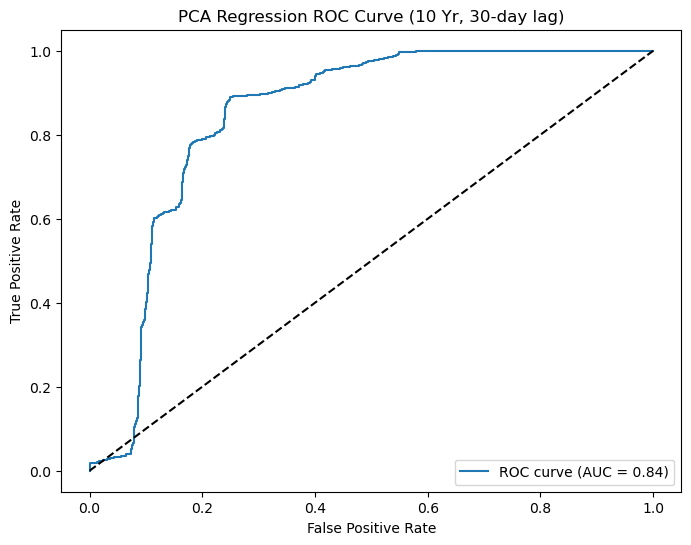

10 Yr - Random Forest Regression Classification Metrics:
Confusion Matrix:
[[366 362]
 [258 469]]
Accuracy: 0.5738831615120275
ROC AUC: 0.6386918617833335


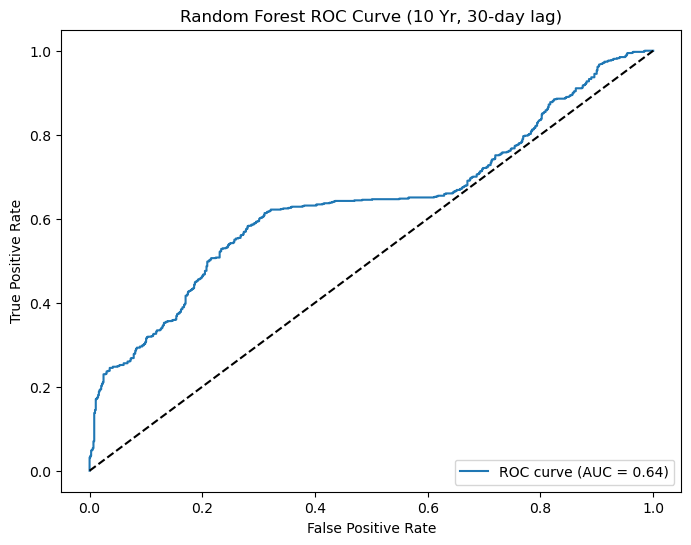

10 Yr - Neural Network Regression Classification Metrics:
Confusion Matrix:
[[138 590]
 [340 387]]
Accuracy: 0.36082474226804123
ROC AUC: 0.2729180207687773


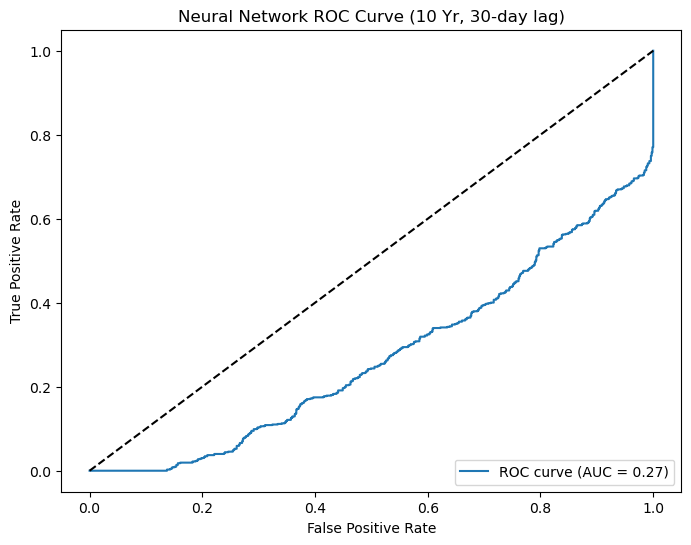

10 Yr - Transformer Regression Classification Metrics:
Confusion Matrix:
[[143 585]
 [207 520]]
Accuracy: 0.4556701030927835
ROC AUC: 0.6259069335066585


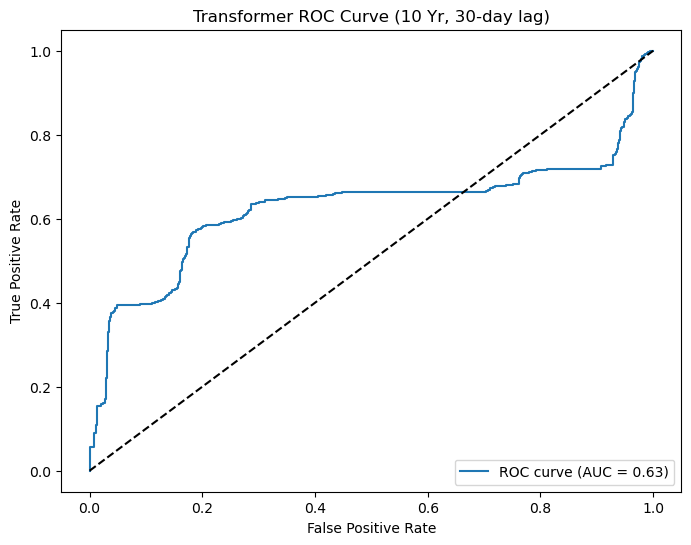

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using PCA predictions: y_pred_pca_10yr and targets: y_test_10yr.
threshold_10yr = np.median(y_test_10yr)
y_test_bin_10yr = (y_test_10yr > threshold_10yr).astype(int)
y_pred_pca_bin_10yr = (y_pred_pca_10yr > threshold_10yr).astype(int)

cm_pca_10yr = confusion_matrix(y_test_bin_10yr, y_pred_pca_bin_10yr)
accuracy_pca_10yr = accuracy_score(y_test_bin_10yr, y_pred_pca_bin_10yr)
fpr_pca_10yr, tpr_pca_10yr, _ = roc_curve(y_test_bin_10yr, y_pred_pca_10yr)
roc_auc_pca_10yr = auc(fpr_pca_10yr, tpr_pca_10yr)

print("10 Yr - PCA Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_pca_10yr)
print("Accuracy:", accuracy_pca_10yr)
print("ROC AUC:", roc_auc_pca_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_pca_10yr, tpr_pca_10yr, label=f'ROC curve (AUC = {roc_auc_pca_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA Regression ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using Random Forest predictions: y_pred_rf_10yr and targets: y_test_10yr.
threshold_rf_10yr = np.median(y_test_10yr)
y_test_bin_rf_10yr = (y_test_10yr > threshold_rf_10yr).astype(int)
y_pred_rf_bin_10yr = (y_pred_rf_10yr > threshold_rf_10yr).astype(int)

cm_rf_10yr = confusion_matrix(y_test_bin_rf_10yr, y_pred_rf_bin_10yr)
accuracy_rf_10yr = accuracy_score(y_test_bin_rf_10yr, y_pred_rf_bin_10yr)
fpr_rf_10yr, tpr_rf_10yr, _ = roc_curve(y_test_bin_rf_10yr, y_pred_rf_10yr)
roc_auc_rf_10yr = auc(fpr_rf_10yr, tpr_rf_10yr)

print("10 Yr - Random Forest Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_rf_10yr)
print("Accuracy:", accuracy_rf_10yr)
print("ROC AUC:", roc_auc_rf_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_10yr, tpr_rf_10yr, label=f'ROC curve (AUC = {roc_auc_rf_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using Neural Network predictions: y_pred_nn_10yr and targets: y_test_10yr.
threshold_nn_10yr = np.median(y_test_10yr)
y_test_bin_nn_10yr = (y_test_10yr > threshold_nn_10yr).astype(int)
y_pred_nn_bin_10yr = (y_pred_nn_10yr > threshold_nn_10yr).astype(int)

cm_nn_10yr = confusion_matrix(y_test_bin_nn_10yr, y_pred_nn_bin_10yr)
accuracy_nn_10yr = accuracy_score(y_test_bin_nn_10yr, y_pred_nn_bin_10yr)
fpr_nn_10yr, tpr_nn_10yr, _ = roc_curve(y_test_bin_nn_10yr, y_pred_nn_10yr)
roc_auc_nn_10yr = auc(fpr_nn_10yr, tpr_nn_10yr)

print("10 Yr - Neural Network Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_nn_10yr)
print("Accuracy:", accuracy_nn_10yr)
print("ROC AUC:", roc_auc_nn_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn_10yr, tpr_nn_10yr, label=f'ROC curve (AUC = {roc_auc_nn_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# For 10 Yr, using Transformer predictions: y_pred_trans_10yr and targets: y_test_seq_10yr.
threshold_trans_10yr = np.median(y_test_seq_10yr)
y_test_bin_trans_10yr = (y_test_seq_10yr > threshold_trans_10yr).astype(int)
y_pred_trans_bin_10yr = (y_pred_trans_10yr > threshold_trans_10yr).astype(int)

cm_trans_10yr = confusion_matrix(y_test_bin_trans_10yr, y_pred_trans_bin_10yr)
accuracy_trans_10yr = accuracy_score(y_test_bin_trans_10yr, y_pred_trans_bin_10yr)
fpr_trans_10yr, tpr_trans_10yr, _ = roc_curve(y_test_bin_trans_10yr, y_pred_trans_10yr)
roc_auc_trans_10yr = auc(fpr_trans_10yr, tpr_trans_10yr)

print("10 Yr - Transformer Regression Classification Metrics:")
print("Confusion Matrix:")
print(cm_trans_10yr)
print("Accuracy:", accuracy_trans_10yr)
print("ROC AUC:", roc_auc_trans_10yr)

plt.figure(figsize=(8,6))
plt.plot(fpr_trans_10yr, tpr_trans_10yr, label=f'ROC curve (AUC = {roc_auc_trans_10yr:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve (10 Yr, 30-day lag)')
plt.legend(loc='lower right')
plt.show()


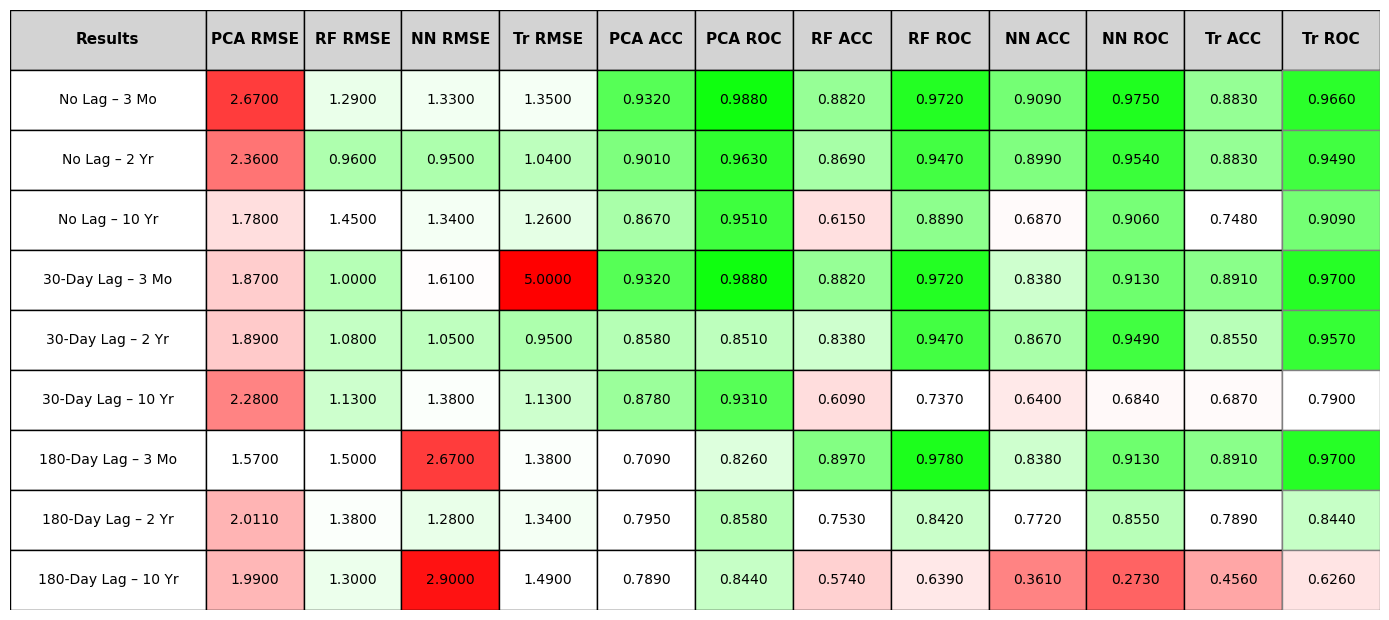

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data setup
data = {
    "Results": [
        "No Lag – 3 Mo",
        "No Lag – 2 Yr",
        "No Lag – 10 Yr",
        "30-Day Lag – 3 Mo",
        "30-Day Lag – 2 Yr",
        "30-Day Lag – 10 Yr",
        "180-Day Lag – 3 Mo",
        "180-Day Lag – 2 Yr",
        "180-Day Lag – 10 Yr"
    ],
    "PCA RMSE": [2.67, 2.36, 1.78, 1.87, 1.89, 2.28, 1.57, 2.011, 1.99],
    "RF RMSE": [1.29, 0.96, 1.45, 1.00, 1.08, 1.13, 1.50, 1.38, 1.30],
    "NN RMSE": [1.33, 0.95, 1.34, 1.61, 1.05, 1.38, 2.67, 1.28, 2.90],
    "Tr RMSE": [1.35, 1.04, 1.26, 5, 0.95, 1.13, 1.38, 1.34, 1.49],
    "PCA ACC": [0.932, 0.901, 0.867, 0.932, 0.858, 0.878, 0.709, 0.795, 0.789],
    "PCA ROC": [0.988, 0.963, 0.951, 0.988, 0.851, 0.931, 0.826, 0.858, 0.844],
    "RF ACC": [0.882, 0.869, 0.615, 0.882, 0.838, 0.609, 0.897, 0.753, 0.574],
    "RF ROC": [0.972, 0.947, 0.889, 0.972, 0.947, 0.737, 0.978, 0.842, 0.639],
    "NN ACC": [0.909, 0.899, 0.687, 0.838, 0.867, 0.640, 0.838, 0.772, 0.361],
    "NN ROC": [0.975, 0.954, 0.906, 0.913, 0.949, 0.684, 0.913, 0.855, 0.273],
    "Tr ACC": [0.883, 0.883, 0.748, 0.891, 0.855, 0.687, 0.891, 0.7890, 0.456],
    "Tr ROC": [0.966, 0.949, 0.909, 0.970, 0.957, 0.790, 0.970, 0.844, 0.626]
}

df = pd.DataFrame(data)
numeric_cols = [col for col in df.columns if col != "Results"]

# Identify RMSE columns
rmse_cols = [col for col in numeric_cols if "RMSE" in col]

def get_color_rmse(val):
    """RMSE coloring with white as midpoint. Green for low, red for high."""
    
    if val >= 1.6:
        ratio = (val - 1.6) / (3.0 - 1.6) if val < 3.0 else 1.0  # Normalize above 1.6
        r = 255  # Fully red
        g = int(255 * (1 - ratio))  # Decrease green
        b = int(255 * (1 - ratio))  # Decrease blue
    elif val <= 1.4:
        ratio = (val - 0.0) / (1.4 - 0.0) if val > 0.0 else 0  # Normalize below 1.4
        r = int(255 * ratio)  # Increase red component
        g = 255  # Fully green
        b = int(255 * ratio)  # Increase blue component
    else:
        r, g, b = 255, 255, 255  # White in the middle (1.4 - 1.6)

    return f'#{r:02x}{g:02x}{b:02x}'

def get_color_default(val):
    """Coloring for ACC/ROC: green for high values, red for low values."""
    
    if val >= 0.8:
        ratio = (val - 0.8) / (1.0 - 0.8) if val < 1.0 else 1.0
        r = int(255 * (1 - ratio))  
        g = 255  
        b = int(255 * (1 - ratio))  
    elif val <= 0.7:
        ratio = (val - 0.0) / (0.7 - 0.0) if val > 0.0 else 0
        r = 255  
        g = int(255 * ratio)  
        b = int(255 * ratio)  
    else:
        r, g, b = 255, 255, 255  

    return f'#{r:02x}{g:02x}{b:02x}'

# Plot setup
n_rows = df.shape[0]
col_widths = [2] + [1] * len(numeric_cols)
n_cols = len(col_widths)

fig, ax = plt.subplots(figsize=(sum(col_widths), n_rows * 0.7))
ax.set_xlim(0, sum(col_widths))
ax.set_ylim(0, n_rows + 1)  # Space for headers
ax.axis('off')

cell_heights = 1

# Headers
for j, col in enumerate(df.columns):
    x = sum(col_widths[:j]) + col_widths[j] / 2
    rect = plt.Rectangle((sum(col_widths[:j]), n_rows), col_widths[j], cell_heights,
                         facecolor="lightgray", edgecolor="black")
    ax.add_patch(rect)
    ax.text(x, n_rows + cell_heights / 2, col, ha="center", va="center", fontsize=11, fontweight="bold")

# Leftmost Column (Results)
for i, label in enumerate(df["Results"]):
    rect = plt.Rectangle((0, n_rows - i - 1), col_widths[0], cell_heights,
                        facecolor="white", edgecolor="black")
    ax.add_patch(rect)
    ax.text(col_widths[0] / 2, n_rows - i - 1 + cell_heights / 2, label,
            ha="center", va="center", fontsize=10)

# Numeric Columns
for j, col in enumerate(numeric_cols, start=1):
    for i, val in enumerate(df[col]):
        val = float(val)
        color = get_color_rmse(val) if col in rmse_cols else get_color_default(val)
        edgecolor = "gray" if col == "Tr ROC" else "black"
        rect = plt.Rectangle((sum(col_widths[:j]), n_rows - i - 1), col_widths[j], cell_heights,
                           facecolor=color, edgecolor=edgecolor, linewidth=1)
        ax.add_patch(rect)
        ax.text(sum(col_widths[:j]) + col_widths[j] / 2, n_rows - i - 1 + cell_heights / 2,
                f"{val:.4f}", ha="center", va="center", fontsize=10)

plt.tight_layout()
plt.show()
